In [1]:
import os
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

#import tensorflow as tf
#from tensorflow.keras import models, layers, optimizers, metrics
#from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [2]:
sns.set()

# Get the Data

In [3]:
path = "../raw_data/"

In [4]:
teste = os.path.join(path, "item_categories.csv")
teste

'../raw_data/item_categories.csv'

In [5]:
categories_ = pd.read_csv(os.path.join(path, "item_categories.csv"))
items_ = pd.read_csv(os.path.join(path, "items.csv"))
sales_ = pd.read_csv(os.path.join(path, "sales_train.csv"))
shops_ = pd.read_csv(os.path.join(path, "shops.csv"))
test_ = pd.read_csv(os.path.join(path, "test.csv"))
sample_ = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [294]:
categories_df = categories_.copy()
items_df = items_.copy()
shops_df = shops_.copy()
sales_df = sales_.copy()
test_df = test_.copy()
sample_df = sample_.copy()

In [295]:
sales_df["date"] = pd.to_datetime(sales_df.date, dayfirst=True)
sales_df = sales_df.merge(items_df[['item_id', 'item_category_id']], on='item_id')
sales_df['item_cnt_day'] = sales_df['item_cnt_day'].astype('int8')
sales_df['date_block_num'] = sales_df['date_block_num'].astype('int8')
sales_df['shop_id'] = sales_df['shop_id'].astype('int32')
sales_df['item_id'] = sales_df['item_id'].astype('int32')
sales_df['item_category_id'] = sales_df['item_category_id'].astype('int32')
sales_df['item_price'] = sales_df['item_price'].astype('float32')
sales_df['final_price'] = sales_df.item_cnt_day * sales_df.item_price
sales_df['final_price'] = sales_df['final_price'].astype('float32')
sales_df.loc[sales_df['final_price'] < 0, ['final_price']] = 0
sales_df.sort_values("date", inplace=True)

In [296]:
sales_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,final_price
400417,2013-01-01,0,51,6622,347.000000,1,30,347.000000
130157,2013-01-01,0,7,1524,2999.000000,1,29,2999.000000
867737,2013-01-01,0,19,18721,149.000000,1,40,149.000000
1004082,2013-01-01,0,54,15133,170.000000,1,67,170.000000
1004086,2013-01-01,0,41,15133,170.000000,1,67,170.000000
...,...,...,...,...,...,...,...,...
1788495,2015-10-31,33,58,3734,3399.000000,1,23,3399.000000
2715396,2015-10-31,33,58,17748,288.149994,1,70,288.149994
1502745,2015-10-31,33,26,20949,5.000000,3,71,15.000000
2931438,2015-10-31,33,46,7223,3999.000000,1,20,3999.000000


In [297]:
sales_df.dtypes

date                datetime64[ns]
date_block_num                int8
shop_id                      int32
item_id                      int32
item_price                 float32
item_cnt_day                  int8
item_category_id             int32
final_price                float32
dtype: object

In [298]:
# analysis in days
freq_analysis = 'd'

# Sorting the Data

## Group by Shop

### Number of Sales

In [299]:
shops_sales = pd.DataFrame()
shops_total_sales_dict = {}

for id in range(shops_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_df[sales_df['shop_id'] == id]
    df = df.resample(freq_analysis, on="date").sum()[["item_cnt_day"]]
    df.rename(columns = {'item_cnt_day':shop_id}, inplace=True)
    shops_total_sales_dict[shop_id] = df[[shop_id]].sum()[0]
    shops_sales = pd.concat([shops_sales, df], axis=1)

shops_sales

,shop_id_0,shop_id_1,shop_id_2,shop_id_3,shop_id_4,shop_id_5,shop_id_6,shop_id_7,shop_id_8,shop_id_9,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,NaN,24,NaN,NaN,NaN,NaN,89,50.0,NaN,...,NaN,136.0,NaN,NaN,415.0,NaN,NaN,NaN,NaN,NaN
2013-01-02,NaN,NaN,76,64.0,166.0,NaN,173.0,208,138.0,NaN,...,231.0,147.0,119.0,149.0,709.0,NaN,375.0,NaN,NaN,155.0
2013-01-03,203.0,204.0,96,43.0,142.0,NaN,187.0,158,121.0,NaN,...,236.0,146.0,100.0,116.0,586.0,NaN,244.0,NaN,NaN,158.0
2013-01-04,352.0,39.0,80,44.0,132.0,NaN,187.0,117,106.0,NaN,...,206.0,121.0,115.0,104.0,495.0,NaN,171.0,NaN,NaN,92.0
2013-01-05,292.0,200.0,72,29.0,116.0,NaN,144.0,125,99.0,NaN,...,155.0,88.0,62.0,141.0,495.0,NaN,191.0,NaN,NaN,101.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-27,NaN,NaN,7,12.0,15.0,15.0,37.0,23,NaN,NaN,...,19.0,NaN,17.0,20.0,NaN,74.0,31.0,56.0,50.0,34.0
2015-10-28,NaN,NaN,23,8.0,17.0,21.0,49.0,22,NaN,NaN,...,26.0,NaN,9.0,23.0,NaN,76.0,15.0,66.0,27.0,14.0
2015-10-29,NaN,NaN,19,13.0,21.0,19.0,45.0,30,NaN,NaN,...,22.0,NaN,37.0,22.0,NaN,61.0,24.0,64.0,37.0,14.0


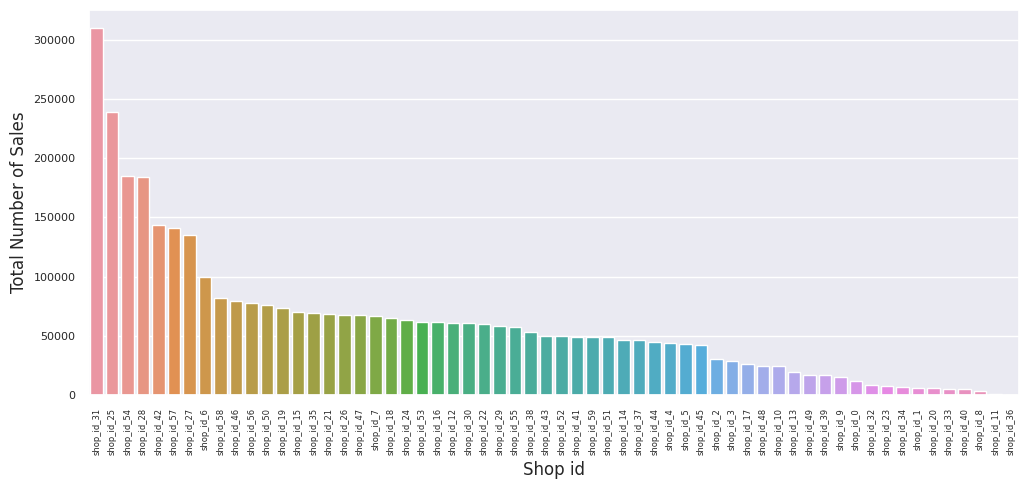

In [300]:
shops_total_sales_df = pd.DataFrame(shops_total_sales_dict, index=[0])
shops_total_sales_df.sort_values(by=0, ascending=False, axis=1, inplace=True)
plt.figure(figsize=(12, 5))
sns.barplot(shops_total_sales_df)
plt.xlabel("Shop id")
plt.ylabel("Total Number of Sales")
plt.tick_params(axis='x', labelsize=6, rotation=90)
plt.tick_params(axis='y', labelsize=8)

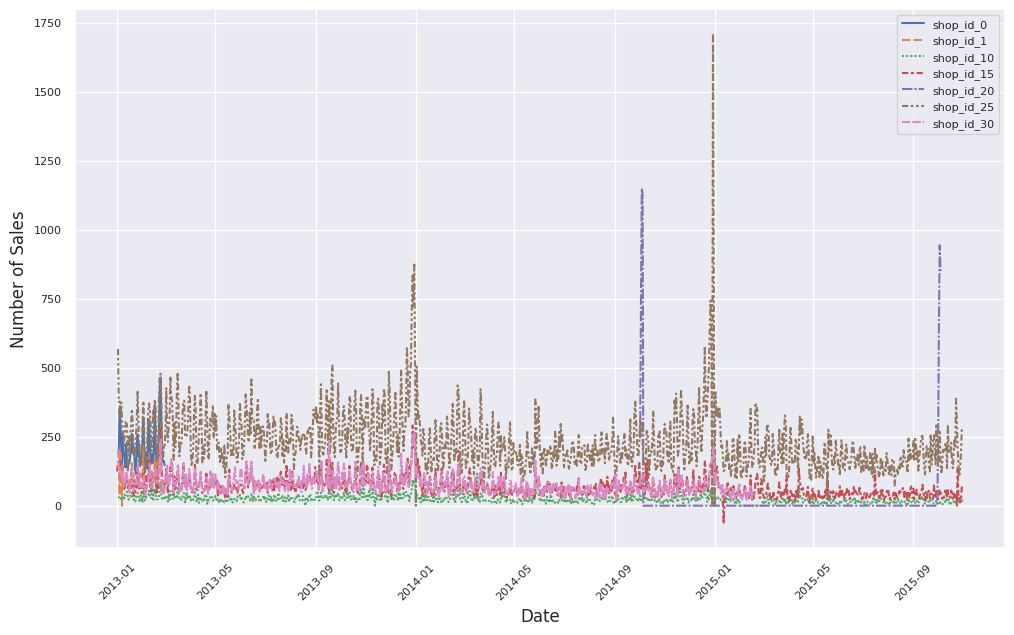

In [301]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=[
    shops_sales.shop_id_0,
    shops_sales.shop_id_1,
    shops_sales.shop_id_10,
    shops_sales.shop_id_15,
    shops_sales.shop_id_20,
    shops_sales.shop_id_25,
    shops_sales.shop_id_30
])
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

### Value of Sales

In [302]:
shops_values = pd.DataFrame()
shops_total_values_dict = {}

for id in range(shops_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_df[sales_df['shop_id'] == id].resample(freq_analysis, on="date").sum()[['final_price']]
    df.rename(columns = {'final_price':shop_id}, inplace=True)
    shops_total_values_dict[shop_id] = df[[shop_id]].sum()[0]
    shops_values = pd.concat([shops_values, df], axis=1)

shops_values

,shop_id_0,shop_id_1,shop_id_2,shop_id_3,shop_id_4,shop_id_5,shop_id_6,shop_id_7,shop_id_8,shop_id_9,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,NaN,31886.000000,NaN,NaN,NaN,NaN,59993.0,44516.0,NaN,...,NaN,41411.0,NaN,NaN,319356.0,NaN,NaN,NaN,NaN,NaN
2013-01-02,NaN,NaN,78307.007812,37305.0,122971.0,NaN,147318.0,147332.0,97050.0,NaN,...,189892.0,56035.0,82783.0,105339.0,520884.0,NaN,227756.0,NaN,NaN,146080.0
2013-01-03,110588.0,108409.0,110521.000000,58891.0,102697.0,NaN,133219.0,124552.0,73278.0,NaN,...,169269.0,31080.0,76037.0,76952.5,377069.0,NaN,168691.0,NaN,NaN,156443.0
2013-01-04,231122.0,45079.0,62854.000000,23231.0,88356.0,NaN,123014.0,90173.0,80960.0,NaN,...,173310.0,37426.0,72385.0,98032.0,287218.0,NaN,101474.0,NaN,NaN,84128.0
2013-01-05,167500.0,103025.0,50181.000000,21771.0,52292.0,NaN,107611.0,101877.0,61110.0,NaN,...,143939.0,47338.0,28667.0,92861.0,401106.0,NaN,94114.0,NaN,NaN,103285.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-27,NaN,NaN,7822.000000,26808.0,18728.0,17955.0,82989.0,26457.0,NaN,NaN,...,53392.0,NaN,19526.0,24200.0,NaN,41341.0,26407.0,84759.0,79933.0,32313.0
2015-10-28,NaN,NaN,18238.000000,13497.0,22458.0,15732.0,41674.0,33288.0,NaN,NaN,...,58897.0,NaN,8136.0,19654.0,NaN,46368.0,10079.0,76346.0,26890.0,40210.0
2015-10-29,NaN,NaN,40685.000000,22784.0,16553.0,23880.0,49688.0,25034.0,NaN,NaN,...,28145.0,NaN,40249.0,21557.0,NaN,39617.0,16158.0,75966.0,31488.0,17027.0


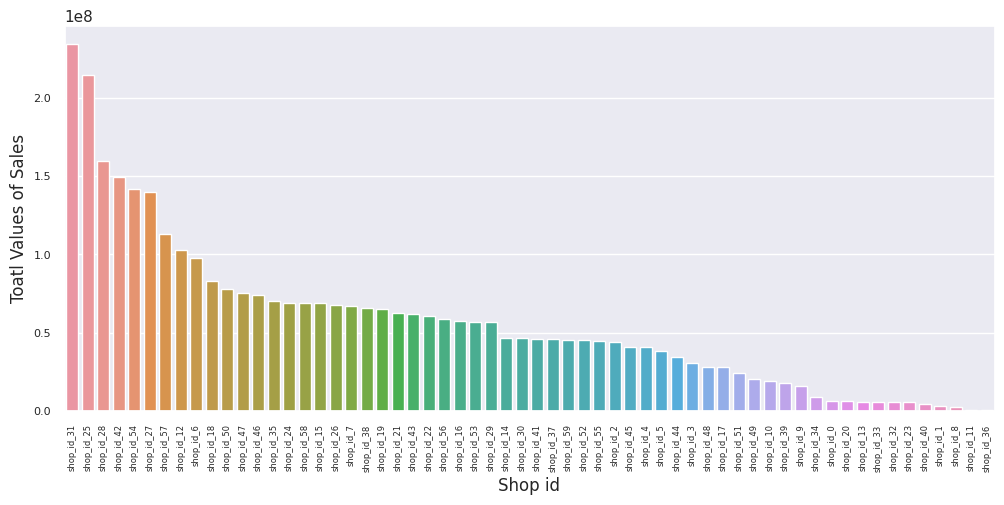

In [303]:
shops_total_values_df = pd.DataFrame(shops_total_values_dict, index=[0])
shops_total_values_df.sort_values(by=0, ascending=False, axis=1, inplace=True)
plt.figure(figsize=(12, 5))
sns.barplot(shops_total_values_df)
plt.xlabel("Shop id")
plt.ylabel("Toatl Values of Sales")
plt.tick_params(axis='x', labelsize=6, rotation=90)
plt.tick_params(axis='y', labelsize=8)

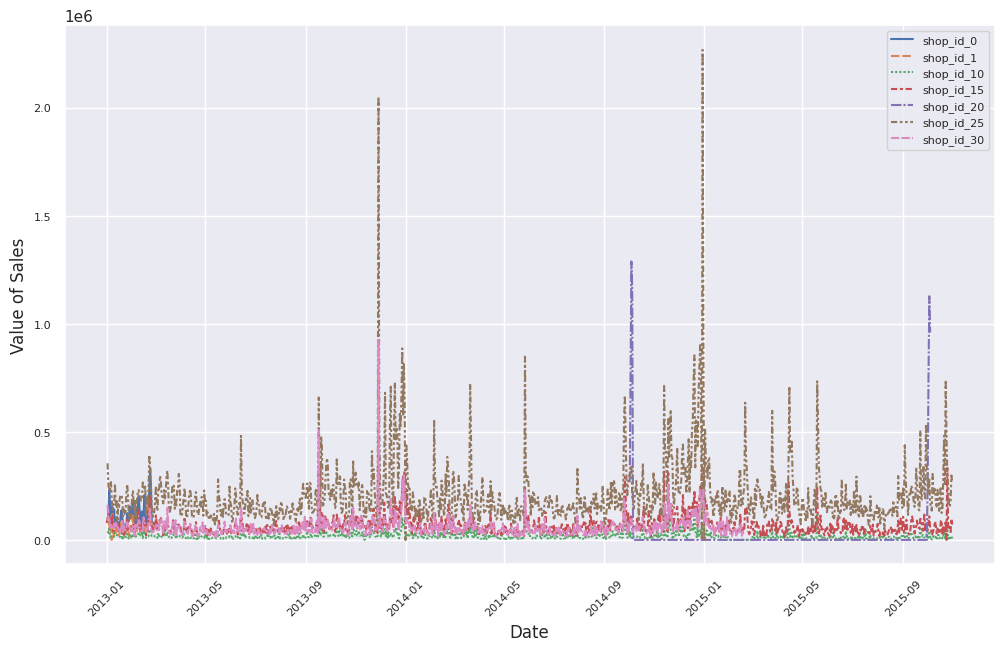

In [304]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=[
    shops_values.shop_id_0,
    shops_values.shop_id_1,
    shops_values.shop_id_10,
    shops_values.shop_id_15,
    shops_values.shop_id_20,
    shops_values.shop_id_25,
    shops_values.shop_id_30
])
plt.xlabel("Date")
plt.ylabel("Value of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

## Group by Category

### Number of Sales

In [305]:
cats_sales = pd.DataFrame()
cats_total_sales_dict = {}

for id in range(categories_df.shape[0]):
    cat_id = f"cat_id_{id}"
    df = sales_df[sales_df['item_category_id'] == id]
    df = df.resample(freq_analysis, on="date").sum()[["item_cnt_day"]]
    df.rename(columns = {'item_cnt_day':cat_id}, inplace=True)
    cats_total_sales_dict[cat_id] = df[[cat_id]].sum()[0]
    cats_sales = pd.concat([cats_sales, df], axis=1)

cats_sales

,cat_id_0,cat_id_1,cat_id_2,cat_id_3,cat_id_4,cat_id_5,cat_id_6,cat_id_7,cat_id_8,cat_id_9,...,cat_id_74,cat_id_75,cat_id_76,cat_id_77,cat_id_78,cat_id_79,cat_id_80,cat_id_81,cat_id_82,cat_id_83
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,NaN,30.0,7,10.0,12,13,NaN,NaN,NaN,...,NaN,17,NaN,4,NaN,1,NaN,1.0,16.0,35
2013-01-02,NaN,NaN,116.0,41,18.0,58,64,NaN,NaN,NaN,...,NaN,95,NaN,31,NaN,7,NaN,9.0,71.0,113
2013-01-03,NaN,NaN,84.0,32,17.0,56,47,NaN,NaN,NaN,...,NaN,126,NaN,30,NaN,1,NaN,7.0,41.0,64
2013-01-04,NaN,NaN,77.0,24,19.0,33,43,NaN,NaN,NaN,...,NaN,167,NaN,16,NaN,7,NaN,8.0,62.0,32
2013-01-05,NaN,NaN,79.0,25,15.0,46,40,NaN,NaN,NaN,...,NaN,110,NaN,18,NaN,7,NaN,7.0,57.0,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-27,NaN,NaN,2.0,19,NaN,3,3,5.0,NaN,8.0,...,NaN,21,7.0,0,1.0,14,NaN,NaN,NaN,3
2015-10-28,NaN,NaN,4.0,17,NaN,1,5,8.0,NaN,137.0,...,NaN,12,5.0,0,2.0,14,NaN,NaN,NaN,12
2015-10-29,NaN,NaN,1.0,34,NaN,0,8,4.0,NaN,17.0,...,NaN,20,6.0,1,2.0,9,NaN,NaN,NaN,6


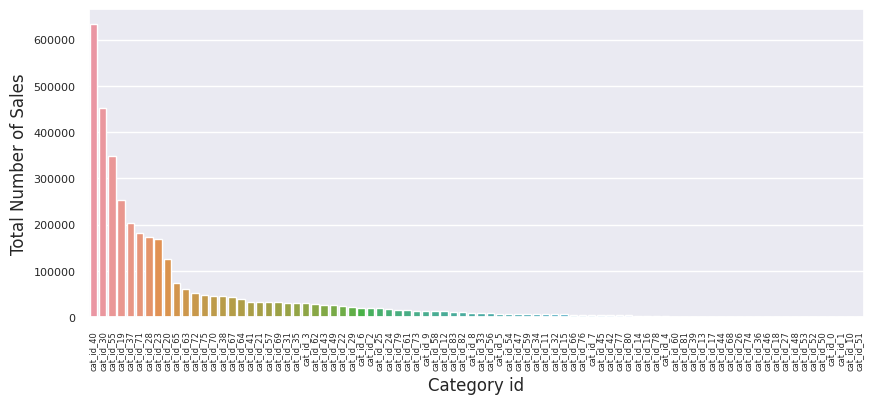

In [306]:
cats_total_sales_df = pd.DataFrame(cats_total_sales_dict, index=[0])
cats_total_sales_df.sort_values(by=0, ascending=False, axis=1, inplace=True)
plt.figure(figsize=(10,4))
sns.barplot(cats_total_sales_df)
plt.xlabel("Category id")
plt.ylabel("Total Number of Sales")
plt.tick_params(axis='x', labelsize=6, rotation=90)
plt.tick_params(axis='y', labelsize=8)

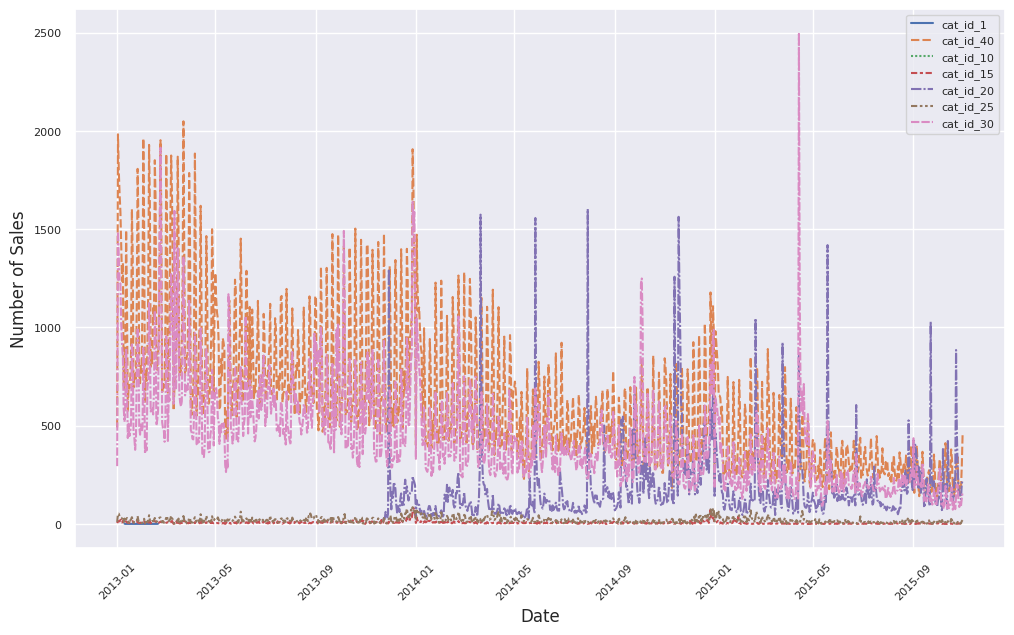

In [307]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=[
    cats_sales.cat_id_1,
    cats_sales.cat_id_40,
    cats_sales.cat_id_10,
    cats_sales.cat_id_15,
    cats_sales.cat_id_20,
    cats_sales.cat_id_25,
    cats_sales.cat_id_30
])
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

### Value of Sales

In [308]:
cats_values = pd.DataFrame()
cats_total_values_dict = {}

for id in range(categories_df.shape[0]):
    cat_id = f"cat_id_{id}"
    df = sales_df[sales_df['item_category_id'] == id].resample(freq_analysis, on="date").sum()[["final_price"]]
    df.rename(columns = {'final_price':cat_id}, inplace=True)
    cats_total_values_dict[cat_id] = df[[cat_id]].sum()[0]
    cats_values = pd.concat([cats_values, df], axis=1)

cats_values

,cat_id_0,cat_id_1,cat_id_2,cat_id_3,cat_id_4,cat_id_5,cat_id_6,cat_id_7,cat_id_8,cat_id_9,...,cat_id_74,cat_id_75,cat_id_76,cat_id_77,cat_id_78,cat_id_79,cat_id_80,cat_id_81,cat_id_82,cat_id_83
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,NaN,59210.679688,3235.660156,5353.0,8647.299805,20769.0,NaN,NaN,NaN,...,NaN,32224.500000,NaN,696.0,NaN,499.0,NaN,79.0,447.0,2580.000000
2013-01-02,NaN,NaN,223635.234375,20455.240234,22371.0,47024.078125,120656.5,NaN,NaN,NaN,...,NaN,188437.000000,NaN,5554.0,NaN,3593.0,NaN,1871.0,2522.0,10122.870117
2013-01-03,NaN,NaN,166675.000000,15711.000000,20409.0,58698.320312,62046.5,NaN,NaN,NaN,...,NaN,210710.796875,NaN,5693.0,NaN,599.0,NaN,951.0,1023.0,5546.000000
2013-01-04,NaN,NaN,146496.515625,11205.000000,18681.5,34044.699219,71060.0,NaN,NaN,NaN,...,NaN,262702.000000,NaN,2985.0,NaN,3393.0,NaN,1568.0,1814.0,3013.000000
2013-01-05,NaN,NaN,142757.015625,11447.000000,14820.0,46100.101562,55896.0,NaN,NaN,NaN,...,NaN,157989.703125,NaN,3792.0,NaN,3623.0,NaN,1989.0,1662.0,3294.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-27,NaN,NaN,6780.000000,48723.000000,NaN,1897.000000,11229.0,15750.0,NaN,2944.000000,...,NaN,56301.000000,12664.0,0.0,216.0,16844.0,NaN,NaN,NaN,477.000000
2015-10-28,NaN,NaN,11868.000000,34802.000000,NaN,499.000000,7850.0,20553.0,NaN,5962.954102,...,NaN,19934.789062,7263.0,0.0,400.0,13937.0,NaN,NaN,NaN,1488.000000
2015-10-29,NaN,NaN,698.000000,70403.000000,NaN,0.000000,22620.0,6468.0,NaN,4903.000000,...,NaN,31703.689453,5490.0,199.0,416.0,9684.0,NaN,NaN,NaN,774.000000


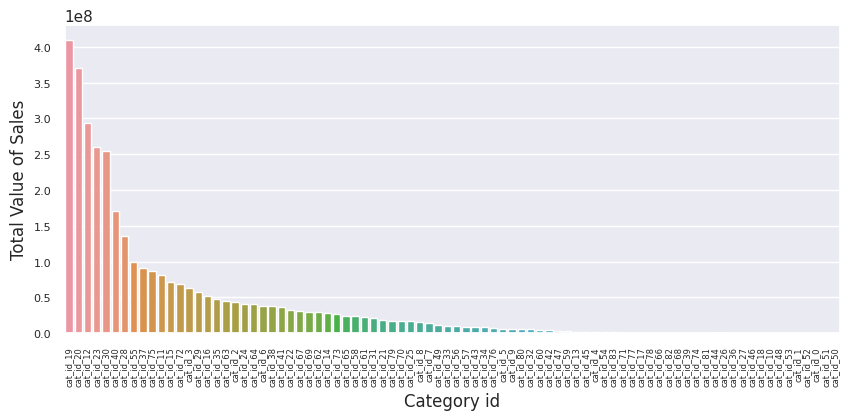

In [309]:
cats_total_values_df = pd.DataFrame(cats_total_values_dict, index=[0])
cats_total_values_df.sort_values(by=0, ascending=False, axis=1, inplace=True)
plt.figure(figsize=(10,4))
sns.barplot(cats_total_values_df)
plt.xlabel("Category id")
plt.ylabel("Total Value of Sales")
plt.tick_params(axis='x', labelsize=6, rotation=90)
plt.tick_params(axis='y', labelsize=8)

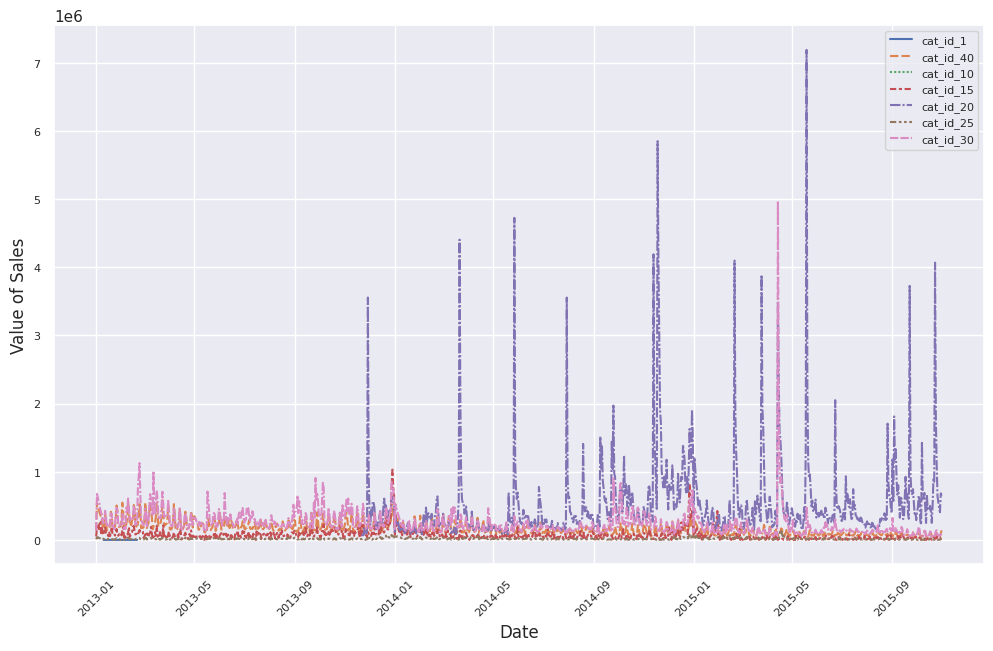

In [310]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=[
    cats_values.cat_id_1,
    cats_values.cat_id_40,
    cats_values.cat_id_10,
    cats_values.cat_id_15,
    cats_values.cat_id_20,
    cats_values.cat_id_25,
    cats_values.cat_id_30
])
plt.xlabel("Date")
plt.ylabel("Value of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

## Group by item

### Sales Count per Week

In [80]:
items_sales = pd.DataFrame()
items_total_sales_dict = {}
items_no_sale = []

for id in range(items_df.shape[0]):
    item_id = f"item_id_{id}"
    df = sales_df[sales_df['item_id'] == id]
    if len(df.index): # same as df.empty, just faster ;-)
        df = df.resample(freq_analysis, on="date").sum()[["item_cnt_day"]]
        df.rename(columns = {'item_cnt_day':item_id}, inplace=True)
        items_total_sales_dict[item_id] = df[[item_id]].sum()[0]
        items_sales = pd.concat([items_sales, df], axis=1)        
    else:
        items_no_sale.append(id)    

items_sales

False
1 item_id_0
False
6 item_id_1
False
2 item_id_2
False
2 item_id_3
False
1 item_id_4
False
1 item_id_5
False
1 item_id_6
False
1 item_id_7
False
2 item_id_8
False
1 item_id_9
False
1 item_id_10
False
1 item_id_11
False
1 item_id_12
False
1 item_id_13
False
1 item_id_14
False
1 item_id_15
False
1 item_id_16
False
1 item_id_17
False
1 item_id_18
False
1 item_id_19
False
1 item_id_20
False
1 item_id_21
False
1 item_id_22
False
1 item_id_23
False
1 item_id_24
False
1 item_id_25
False
1 item_id_26
False
42 item_id_27
False
86 item_id_28
False
14 item_id_29
False
1383 item_id_30
False
1110 item_id_31
False
1884 item_id_32
False
830 item_id_33
False
122 item_id_34
False
180 item_id_35
False
82 item_id_36
False
145 item_id_37
False
70 item_id_38
False
7 item_id_39
False
94 item_id_40
False
43 item_id_41
False
109 item_id_42
False
9 item_id_43
False
103 item_id_44
False
174 item_id_45
False
46 item_id_46
False
55 item_id_47
False
61 item_id_48
False
186 item_id_49
False
2 item_id_50
False


False
1 item_id_418
False
1 item_id_419
False
1 item_id_420
False
88 item_id_421
False
1 item_id_422
False
5 item_id_423
False
5 item_id_424
False
1 item_id_425
False
1 item_id_426
False
1 item_id_427
True
False
3 item_id_429
True
False
1 item_id_431
False
2 item_id_432
False
1 item_id_433
False
1 item_id_434
False
13 item_id_435
False
1 item_id_436
False
1 item_id_437
False
33 item_id_438
False
18 item_id_439
False
1 item_id_440
False
1 item_id_441
False
1 item_id_442
False
1 item_id_443
False
1 item_id_444
False
1 item_id_445
False
1 item_id_446
False
1 item_id_447
False
158 item_id_448
False
1 item_id_449
False
1 item_id_450
False
15 item_id_451
False
1 item_id_452
False
6 item_id_453
True
False
2 item_id_455
False
1 item_id_456
False
1 item_id_457
False
1 item_id_458
False
1 item_id_459
False
11 item_id_460
False
1 item_id_461
False
1 item_id_462
False
1 item_id_463
False
989 item_id_464
False
1 item_id_465
False
1 item_id_466
False
1 item_id_467
False
1 item_id_468
False
1 item_id

False
1135 item_id_839
False
1 item_id_840
False
3 item_id_841
False
14 item_id_842
False
11 item_id_843
False
9 item_id_844
False
2 item_id_845
False
5 item_id_846
False
15 item_id_847
False
9 item_id_848
False
30 item_id_849
False
1 item_id_850
False
10 item_id_851
False
5 item_id_852
False
14 item_id_853
False
1 item_id_854
False
1 item_id_855
False
5 item_id_856
False
1 item_id_857
False
7 item_id_858
False
11 item_id_859
False
1 item_id_860
False
1 item_id_861
False
19 item_id_862
False
1 item_id_863
False
14 item_id_864
False
4 item_id_865
False
1 item_id_866
False
32 item_id_867
False
40 item_id_868
False
30 item_id_869
False
1 item_id_870
False
21 item_id_871
False
2 item_id_872
False
1 item_id_873
False
13 item_id_874
False
3 item_id_875
False
1 item_id_876
False
22 item_id_877
False
1 item_id_878
False
9 item_id_879
False
3 item_id_880
False
1 item_id_881
False
9 item_id_882
False
2 item_id_883
False
1 item_id_884
False
19 item_id_885
False
1 item_id_886
False
7 item_id_887
F

False
8 item_id_1240
False
257 item_id_1241
False
7 item_id_1242
False
255 item_id_1243
False
5 item_id_1244
False
17 item_id_1245
True
False
426 item_id_1247
False
13 item_id_1248
False
1617 item_id_1249
False
48 item_id_1250
False
15 item_id_1251
True
True
True
False
25 item_id_1255
False
200 item_id_1256
False
226 item_id_1257
False
1 item_id_1258
False
37 item_id_1259
False
16 item_id_1260
False
87 item_id_1261
False
1 item_id_1262
False
1 item_id_1263
False
2 item_id_1264
False
1 item_id_1265
False
53 item_id_1266
False
1 item_id_1267
False
11 item_id_1268
False
6 item_id_1269
False
132 item_id_1270
False
11 item_id_1271
False
20 item_id_1272
False
41 item_id_1273
False
16 item_id_1274
False
43 item_id_1275
False
2 item_id_1276
False
1 item_id_1277
False
1 item_id_1278
False
19 item_id_1279
False
6 item_id_1280
False
1 item_id_1281
False
73 item_id_1282
False
32 item_id_1283
True
False
332 item_id_1285
False
69 item_id_1286
False
119 item_id_1287
False
187 item_id_1288
False
150 i

False
40 item_id_1627
False
10 item_id_1628
False
18 item_id_1629
False
16 item_id_1630
False
10 item_id_1631
False
8 item_id_1632
False
1 item_id_1633
False
9 item_id_1634
False
44 item_id_1635
False
6 item_id_1636
False
15 item_id_1637
False
2 item_id_1638
False
1 item_id_1639
False
1 item_id_1640
False
24 item_id_1641
False
1 item_id_1642
False
2 item_id_1643
False
4 item_id_1644
False
57 item_id_1645
False
3 item_id_1646
False
11 item_id_1647
False
5 item_id_1648
False
1 item_id_1649
False
30 item_id_1650
False
35 item_id_1651
False
13 item_id_1652
False
28 item_id_1653
False
4 item_id_1654
False
14 item_id_1655
False
30 item_id_1656
False
94 item_id_1657
False
4 item_id_1658
False
1 item_id_1659
False
4 item_id_1660
False
1 item_id_1661
False
1 item_id_1662
False
29 item_id_1663
False
2 item_id_1664
False
28 item_id_1665
False
17 item_id_1666
False
16 item_id_1667
False
9 item_id_1668
False
3 item_id_1669
False
317 item_id_1670
False
47 item_id_1671
False
27 item_id_1672
False
394

False
17 item_id_2011
False
14 item_id_2012
False
9 item_id_2013
False
19 item_id_2014
False
19 item_id_2015
False
21 item_id_2016
False
13 item_id_2017
False
13 item_id_2018
False
7 item_id_2019
False
26 item_id_2020
False
28 item_id_2021
False
19 item_id_2022
False
13 item_id_2023
False
14 item_id_2024
False
7 item_id_2025
False
6 item_id_2026
False
4 item_id_2027
False
11 item_id_2028
False
15 item_id_2029
False
32 item_id_2030
False
186 item_id_2031
False
162 item_id_2032
False
2 item_id_2033
False
5 item_id_2034
False
144 item_id_2035
False
18 item_id_2036
False
7 item_id_2037
False
16 item_id_2038
False
530 item_id_2039
False
202 item_id_2040
False
90 item_id_2041
False
23 item_id_2042
False
1 item_id_2043
False
1 item_id_2044
False
2 item_id_2045
False
2 item_id_2046
False
752 item_id_2047
False
10 item_id_2048
False
88 item_id_2049
False
155 item_id_2050
False
8 item_id_2051
False
1 item_id_2052
False
1 item_id_2053
False
2 item_id_2054
False
1 item_id_2055
False
24 item_id_205

False
283 item_id_2400
False
29 item_id_2401
False
1 item_id_2402
False
19 item_id_2403
False
9 item_id_2404
False
8 item_id_2405
False
80 item_id_2406
False
538 item_id_2407
False
5 item_id_2408
False
41 item_id_2409
False
2 item_id_2410
False
1 item_id_2411
False
47 item_id_2412
False
17 item_id_2413
False
3 item_id_2414
False
653 item_id_2415
False
4487 item_id_2416
False
690 item_id_2417
False
19 item_id_2418
False
1 item_id_2419
True
False
2 item_id_2421
False
442 item_id_2422
False
395 item_id_2423
False
320 item_id_2424
False
5 item_id_2425
True
True
True
False
1273 item_id_2429
False
886 item_id_2430
False
350 item_id_2431
False
107 item_id_2432
False
1 item_id_2433
True
False
1 item_id_2435
False
349 item_id_2436
False
613 item_id_2437
False
7 item_id_2438
False
1048 item_id_2439
False
20 item_id_2440
False
173 item_id_2441
False
542 item_id_2442
False
726 item_id_2443
False
41 item_id_2444
False
5056 item_id_2445
False
1502 item_id_2446
False
1358 item_id_2447
False
545 item_

False
183 item_id_2785
False
14 item_id_2786
False
8 item_id_2787
False
74 item_id_2788
False
7 item_id_2789
False
6 item_id_2790
False
78 item_id_2791
False
17 item_id_2792
False
1 item_id_2793
False
1 item_id_2794
False
25 item_id_2795
False
63 item_id_2796
False
35 item_id_2797
False
544 item_id_2798
False
809 item_id_2799
False
269 item_id_2800
False
69 item_id_2801
False
5 item_id_2802
False
3 item_id_2803
False
25 item_id_2804
False
1 item_id_2805
False
695 item_id_2806
False
3 item_id_2807
False
7479 item_id_2808
False
1569 item_id_2809
False
958 item_id_2810
False
199 item_id_2811
False
107 item_id_2812
False
835 item_id_2813
False
2678 item_id_2814
False
305 item_id_2815
False
685 item_id_2816
False
1057 item_id_2817
False
391 item_id_2818
False
175 item_id_2819
False
29 item_id_2820
False
3 item_id_2821
False
81 item_id_2822
False
1 item_id_2823
False
10 item_id_2824
False
1 item_id_2825
False
3 item_id_2826
False
333 item_id_2827
False
13 item_id_2828
False
2 item_id_2829
Fa

False
215 item_id_3160
False
11 item_id_3161
False
3 item_id_3162
False
7 item_id_3163
False
134 item_id_3164
False
20 item_id_3165
False
3 item_id_3166
False
13 item_id_3167
False
58 item_id_3168
False
5 item_id_3169
False
90 item_id_3170
False
20 item_id_3171
False
3 item_id_3172
False
206 item_id_3173
False
37 item_id_3174
False
218 item_id_3175
False
1 item_id_3176
False
1 item_id_3177
False
13 item_id_3178
False
16 item_id_3179
False
1 item_id_3180
False
84 item_id_3181
False
57 item_id_3182
False
4615 item_id_3183
False
392 item_id_3184
False
402 item_id_3185
False
1794 item_id_3186
False
237 item_id_3187
False
15 item_id_3188
False
1 item_id_3189
False
1 item_id_3190
False
1 item_id_3191
False
42 item_id_3192
False
229 item_id_3193
False
3 item_id_3194
False
9 item_id_3195
False
492 item_id_3196
False
233 item_id_3197
False
41 item_id_3198
False
4 item_id_3199
False
32 item_id_3200
False
19 item_id_3201
False
12 item_id_3202
False
13 item_id_3203
False
11 item_id_3204
False
11 i

False
91 item_id_3545
False
197 item_id_3546
False
52 item_id_3547
False
39 item_id_3548
False
3 item_id_3549
False
1 item_id_3550
False
1 item_id_3551
False
747 item_id_3552
False
751 item_id_3553
False
1413 item_id_3554
False
13 item_id_3555
False
2489 item_id_3556
False
327 item_id_3557
False
111 item_id_3558
False
9 item_id_3559
False
1 item_id_3560
False
1 item_id_3561
False
49 item_id_3562
False
2 item_id_3563
False
1 item_id_3564
False
309 item_id_3565
False
137 item_id_3566
False
4 item_id_3567
False
1 item_id_3568
False
39 item_id_3569
False
31 item_id_3570
True
False
8 item_id_3572
False
1 item_id_3573
False
90 item_id_3574
False
3 item_id_3575
False
17 item_id_3576
False
120 item_id_3577
False
16 item_id_3578
True
False
276 item_id_3580
False
10 item_id_3581
False
50 item_id_3582
False
1 item_id_3583
False
11 item_id_3584
False
1 item_id_3585
False
8 item_id_3586
False
4 item_id_3587
False
4 item_id_3588
False
1 item_id_3589
False
1 item_id_3590
False
51 item_id_3591
False
3

False
1 item_id_3926
False
102 item_id_3927
False
3568 item_id_3928
False
465 item_id_3929
False
1071 item_id_3930
False
13 item_id_3931
False
420 item_id_3932
False
706 item_id_3933
False
1198 item_id_3934
False
792 item_id_3935
False
591 item_id_3936
False
457 item_id_3937
False
980 item_id_3938
False
599 item_id_3939
False
1 item_id_3940
False
134 item_id_3941
False
61 item_id_3942
False
367 item_id_3943
False
122 item_id_3944
False
112 item_id_3945
False
500 item_id_3946
False
19 item_id_3947
False
2 item_id_3948
False
9 item_id_3949
False
34 item_id_3950
False
3 item_id_3951
False
19 item_id_3952
False
71 item_id_3953
False
30 item_id_3954
False
46 item_id_3955
False
12 item_id_3956
False
18 item_id_3957
False
232 item_id_3958
False
39 item_id_3959
False
122 item_id_3960
False
153 item_id_3961
False
26 item_id_3962
False
19 item_id_3963
False
104 item_id_3964
False
245 item_id_3965
False
83 item_id_3966
False
492 item_id_3967
False
2 item_id_3968
False
40 item_id_3969
False
149 it

False
248 item_id_4305
False
1 item_id_4306
False
169 item_id_4307
False
60 item_id_4308
False
41 item_id_4309
True
False
14 item_id_4311
False
19 item_id_4312
False
1 item_id_4313
False
12 item_id_4314
False
12 item_id_4315
False
16 item_id_4316
False
2 item_id_4317
True
False
1 item_id_4319
False
17 item_id_4320
False
10 item_id_4321
False
16 item_id_4322
False
390 item_id_4323
False
1 item_id_4324
False
81 item_id_4325
False
3 item_id_4326
False
27 item_id_4327
False
64 item_id_4328
False
1 item_id_4329
False
126 item_id_4330
False
25 item_id_4331
False
1328 item_id_4332
False
315 item_id_4333
False
752 item_id_4334
False
226 item_id_4335
False
423 item_id_4336
False
200 item_id_4337
False
352 item_id_4338
False
70 item_id_4339
False
9 item_id_4340
False
7 item_id_4341
False
4 item_id_4342
False
3 item_id_4343
False
88 item_id_4344
False
798 item_id_4345
False
9 item_id_4346
False
6 item_id_4347
False
99 item_id_4348
False
269 item_id_4349
False
233 item_id_4350
False
3334 item_id_4

False
7 item_id_4681
False
1 item_id_4682
False
8 item_id_4683
False
1 item_id_4684
False
7 item_id_4685
False
70 item_id_4686
False
3 item_id_4687
False
507 item_id_4688
False
273 item_id_4689
False
4 item_id_4690
False
251 item_id_4691
False
78 item_id_4692
False
10 item_id_4693
False
218 item_id_4694
False
50 item_id_4695
False
10 item_id_4696
False
45 item_id_4697
False
31 item_id_4698
False
23 item_id_4699
False
44 item_id_4700
False
141 item_id_4701
False
159 item_id_4702
False
46 item_id_4703
False
47 item_id_4704
False
73 item_id_4705
False
422 item_id_4706
False
20 item_id_4707
False
75 item_id_4708
False
16 item_id_4709
False
354 item_id_4710
False
145 item_id_4711
False
554 item_id_4712
False
41 item_id_4713
False
37 item_id_4714
False
314 item_id_4715
False
1 item_id_4716
False
1540 item_id_4717
False
1 item_id_4718
False
606 item_id_4719
False
31 item_id_4720
False
418 item_id_4721
False
67 item_id_4722
False
1241 item_id_4723
False
573 item_id_4724
False
2 item_id_4725
Fa

False
156 item_id_5055
False
1 item_id_5056
False
29 item_id_5057
False
23 item_id_5058
False
139 item_id_5059
False
1048 item_id_5060
False
3 item_id_5061
False
68 item_id_5062
False
113 item_id_5063
True
False
312 item_id_5065
False
162 item_id_5066
False
13 item_id_5067
False
205 item_id_5068
False
3 item_id_5069
False
514 item_id_5070
False
1 item_id_5071
False
1 item_id_5072
False
1 item_id_5073
False
6 item_id_5074
False
11 item_id_5075
False
15 item_id_5076
False
6 item_id_5077
False
6 item_id_5078
False
6 item_id_5079
False
2 item_id_5080
False
6 item_id_5081
False
6 item_id_5082
False
70 item_id_5083
False
6 item_id_5084
False
2 item_id_5085
False
10 item_id_5086
False
68 item_id_5087
False
16 item_id_5088
False
70 item_id_5089
False
31 item_id_5090
False
10 item_id_5091
False
133 item_id_5092
False
77 item_id_5093
False
25 item_id_5094
False
84 item_id_5095
False
262 item_id_5096
False
46 item_id_5097
False
47 item_id_5098
False
24 item_id_5099
False
52 item_id_5100
False
56 

False
11 item_id_5437
False
34 item_id_5438
False
140 item_id_5439
False
218 item_id_5440
True
False
1 item_id_5442
False
23 item_id_5443
False
507 item_id_5444
False
16 item_id_5445
False
53 item_id_5446
False
106 item_id_5447
False
53 item_id_5448
False
58 item_id_5449
False
3 item_id_5450
False
4 item_id_5451
False
6 item_id_5452
False
2 item_id_5453
False
37 item_id_5454
False
48 item_id_5455
False
214 item_id_5456
False
317 item_id_5457
False
7 item_id_5458
False
1182 item_id_5459
False
138 item_id_5460
False
22 item_id_5461
False
13 item_id_5462
False
1 item_id_5463
False
26 item_id_5464
False
3 item_id_5465
False
18 item_id_5466
False
84 item_id_5467
False
5 item_id_5468
False
150 item_id_5469
False
223 item_id_5470
False
9 item_id_5471
False
38 item_id_5472
False
94 item_id_5473
False
1 item_id_5474
False
2 item_id_5475
False
11 item_id_5476
False
10 item_id_5477
False
13 item_id_5478
False
1 item_id_5479
False
12 item_id_5480
False
11 item_id_5481
False
20 item_id_5482
False
5

False
153 item_id_5818
False
1007 item_id_5819
False
3395 item_id_5820
False
5389 item_id_5821
False
9408 item_id_5822
False
4974 item_id_5823
False
161 item_id_5824
False
164 item_id_5825
True
False
1042 item_id_5827
False
405 item_id_5828
False
205 item_id_5829
False
269 item_id_5830
False
2 item_id_5831
False
142 item_id_5832
False
150 item_id_5833
False
155 item_id_5834
False
150 item_id_5835
False
102 item_id_5836
False
1087 item_id_5837
False
361 item_id_5838
False
101 item_id_5839
False
116 item_id_5840
False
63 item_id_5841
False
44 item_id_5842
True
True
False
86 item_id_5845
False
3 item_id_5846
False
22 item_id_5847
False
174 item_id_5848
False
35 item_id_5849
False
7 item_id_5850
False
23 item_id_5851
False
1 item_id_5852
False
2 item_id_5853
False
1 item_id_5854
False
2 item_id_5855
False
13 item_id_5856
False
1 item_id_5857
False
271 item_id_5858
False
20 item_id_5859
False
23 item_id_5860
False
22 item_id_5861
False
268 item_id_5862
False
25 item_id_5863
False
35 item_id

False
56 item_id_6197
False
15 item_id_6198
False
9 item_id_6199
False
198 item_id_6200
False
1 item_id_6201
False
515 item_id_6202
False
31 item_id_6203
False
132 item_id_6204
False
3 item_id_6205
False
80 item_id_6206
False
23 item_id_6207
False
1 item_id_6208
False
1 item_id_6209
False
1 item_id_6210
False
69 item_id_6211
False
47 item_id_6212
False
7 item_id_6213
False
33 item_id_6214
False
1 item_id_6215
False
6 item_id_6216
False
48 item_id_6217
False
2 item_id_6218
False
16 item_id_6219
False
24 item_id_6220
False
8 item_id_6221
False
221 item_id_6222
False
45 item_id_6223
False
43 item_id_6224
False
14 item_id_6225
False
157 item_id_6226
False
5 item_id_6227
False
18 item_id_6228
False
185 item_id_6229
False
1 item_id_6230
False
42 item_id_6231
False
114 item_id_6232
False
126 item_id_6233
False
117 item_id_6234
False
2 item_id_6235
False
109 item_id_6236
False
25 item_id_6237
False
489 item_id_6238
False
40 item_id_6239
False
56 item_id_6240
False
28 item_id_6241
False
15 item

False
132 item_id_6583
False
198 item_id_6584
False
31 item_id_6585
False
177 item_id_6586
False
175 item_id_6587
False
138 item_id_6588
False
154 item_id_6589
False
136 item_id_6590
False
68 item_id_6591
False
214 item_id_6592
False
168 item_id_6593
False
138 item_id_6594
False
90 item_id_6595
False
81 item_id_6596
False
155 item_id_6597
False
241 item_id_6598
False
145 item_id_6599
False
202 item_id_6600
False
201 item_id_6601
False
22 item_id_6602
False
8 item_id_6603
False
189 item_id_6604
False
200 item_id_6605
False
256 item_id_6606
False
230 item_id_6607
False
338 item_id_6608
False
195 item_id_6609
False
1 item_id_6610
False
323 item_id_6611
False
365 item_id_6612
False
309 item_id_6613
False
3 item_id_6614
False
131 item_id_6615
False
310 item_id_6616
False
53 item_id_6617
False
258 item_id_6618
False
262 item_id_6619
False
31 item_id_6620
False
49 item_id_6621
False
629 item_id_6622
False
302 item_id_6623
False
531 item_id_6624
False
188 item_id_6625
False
307 item_id_6626
Fa

False
9 item_id_6967
False
7 item_id_6968
False
20 item_id_6969
False
108 item_id_6970
False
48 item_id_6971
False
12 item_id_6972
False
9 item_id_6973
False
6 item_id_6974
False
32 item_id_6975
False
72 item_id_6976
False
19 item_id_6977
False
35 item_id_6978
False
2 item_id_6979
False
19 item_id_6980
False
6 item_id_6981
False
8 item_id_6982
False
4 item_id_6983
False
38 item_id_6984
False
23 item_id_6985
False
5 item_id_6986
False
14 item_id_6987
False
5 item_id_6988
False
6 item_id_6989
False
33 item_id_6990
False
76 item_id_6991
False
1 item_id_6992
False
33 item_id_6993
False
28 item_id_6994
False
9 item_id_6995
True
False
15 item_id_6997
False
690 item_id_6998
False
18 item_id_6999
False
160 item_id_7000
False
175 item_id_7001
False
151 item_id_7002
False
1740 item_id_7003
False
776 item_id_7004
False
745 item_id_7005
False
697 item_id_7006
False
435 item_id_7007
False
38 item_id_7008
False
86 item_id_7009
False
19 item_id_7010
False
42 item_id_7011
False
1 item_id_7012
False
3 

False
86 item_id_7344
False
93 item_id_7345
False
33 item_id_7346
False
59 item_id_7347
False
16 item_id_7348
False
119 item_id_7349
False
142 item_id_7350
False
121 item_id_7351
False
38 item_id_7352
False
45 item_id_7353
False
6 item_id_7354
False
1 item_id_7355
False
27 item_id_7356
False
2 item_id_7357
False
91 item_id_7358
False
37 item_id_7359
False
40 item_id_7360
False
1 item_id_7361
False
2 item_id_7362
False
48 item_id_7363
False
64 item_id_7364
False
66 item_id_7365
False
105 item_id_7366
False
46 item_id_7367
False
140 item_id_7368
False
103 item_id_7369
False
1 item_id_7370
False
155 item_id_7371
False
35 item_id_7372
False
26 item_id_7373
False
52 item_id_7374
False
38 item_id_7375
False
2 item_id_7376
False
46 item_id_7377
False
21 item_id_7378
False
1 item_id_7379
False
25 item_id_7380
False
58 item_id_7381
False
15 item_id_7382
False
1 item_id_7383
False
245 item_id_7384
False
32 item_id_7385
False
15 item_id_7386
False
13 item_id_7387
False
135 item_id_7388
False
17 i

False
93 item_id_7726
True
True
True
True
False
1 item_id_7731
False
4 item_id_7732
False
12 item_id_7733
False
100 item_id_7734
False
68 item_id_7735
False
2083 item_id_7736
False
1059 item_id_7737
False
551 item_id_7738
False
448 item_id_7739
False
8 item_id_7740
False
449 item_id_7741
False
9 item_id_7742
False
6 item_id_7743
False
85 item_id_7744
False
26 item_id_7745
False
35 item_id_7746
False
21 item_id_7747
False
28 item_id_7748
False
2 item_id_7749
False
3 item_id_7750
False
2 item_id_7751
False
2 item_id_7752
False
1 item_id_7753
False
1 item_id_7754
False
1 item_id_7755
False
1 item_id_7756
False
3 item_id_7757
False
4 item_id_7758
False
3 item_id_7759
False
4 item_id_7760
False
3 item_id_7761
False
3 item_id_7762
False
3 item_id_7763
False
3 item_id_7764
False
2 item_id_7765
True
False
3 item_id_7767
False
3 item_id_7768
False
5 item_id_7769
False
1226 item_id_7770
False
3 item_id_7771
False
1 item_id_7772
False
2 item_id_7773
False
40 item_id_7774
False
6 item_id_7775
Fals

False
109 item_id_8102
False
44 item_id_8103
False
16 item_id_8104
False
21 item_id_8105
False
50 item_id_8106
False
128 item_id_8107
False
50 item_id_8108
False
33 item_id_8109
False
21 item_id_8110
False
1 item_id_8111
False
62 item_id_8112
False
16 item_id_8113
False
4 item_id_8114
False
5 item_id_8115
False
11 item_id_8116
False
30 item_id_8117
False
13 item_id_8118
False
11 item_id_8119
False
3 item_id_8120
False
210 item_id_8121
False
3 item_id_8122
False
55 item_id_8123
False
45 item_id_8124
False
55 item_id_8125
False
49 item_id_8126
False
12 item_id_8127
False
44 item_id_8128
False
35 item_id_8129
False
68 item_id_8130
False
30 item_id_8131
False
23 item_id_8132
False
161 item_id_8133
False
50 item_id_8134
False
71 item_id_8135
False
62 item_id_8136
False
47 item_id_8137
False
3 item_id_8138
False
79 item_id_8139
False
106 item_id_8140
False
2 item_id_8141
False
340 item_id_8142
False
4 item_id_8143
False
67 item_id_8144
False
9 item_id_8145
False
1 item_id_8146
False
55 item_

False
63 item_id_8481
False
191 item_id_8482
False
77 item_id_8483
False
164 item_id_8484
False
49 item_id_8485
False
53 item_id_8486
False
53 item_id_8487
False
7 item_id_8488
False
10 item_id_8489
False
11 item_id_8490
False
81 item_id_8491
False
69 item_id_8492
False
121 item_id_8493
False
56 item_id_8494
False
54 item_id_8495
False
71 item_id_8496
False
262 item_id_8497
False
79 item_id_8498
False
1 item_id_8499
False
2 item_id_8500
False
4 item_id_8501
False
15 item_id_8502
False
12 item_id_8503
False
17 item_id_8504
False
8 item_id_8505
False
1 item_id_8506
False
40 item_id_8507
False
453 item_id_8508
False
166 item_id_8509
False
51 item_id_8510
False
22 item_id_8511
False
24 item_id_8512
False
137 item_id_8513
False
8 item_id_8514
False
2 item_id_8515
False
30 item_id_8516
False
1 item_id_8517
False
1 item_id_8518
False
2 item_id_8519
False
3 item_id_8520
False
3 item_id_8521
False
2 item_id_8522
False
4 item_id_8523
False
4 item_id_8524
False
2 item_id_8525
False
4 item_id_8526

False
40 item_id_8862
False
872 item_id_8863
False
1 item_id_8864
False
1 item_id_8865
False
3 item_id_8866
False
20 item_id_8867
False
7 item_id_8868
False
3 item_id_8869
False
161 item_id_8870
False
74 item_id_8871
False
117 item_id_8872
False
98 item_id_8873
False
235 item_id_8874
False
18 item_id_8875
False
33 item_id_8876
False
145 item_id_8877
False
28 item_id_8878
False
97 item_id_8879
False
67 item_id_8880
False
65 item_id_8881
False
9 item_id_8882
False
39 item_id_8883
False
33 item_id_8884
False
11 item_id_8885
False
167 item_id_8886
False
4 item_id_8887
False
454 item_id_8888
False
17 item_id_8889
True
False
276 item_id_8891
False
91 item_id_8892
False
64 item_id_8893
False
80 item_id_8894
False
1 item_id_8895
False
5 item_id_8896
False
1 item_id_8897
False
329 item_id_8898
False
137 item_id_8899
False
2 item_id_8900
False
4 item_id_8901
False
42 item_id_8902
False
70 item_id_8903
False
7 item_id_8904
False
1 item_id_8905
False
17 item_id_8906
False
9 item_id_8907
False
16 i

False
69 item_id_9245
False
400 item_id_9246
False
128 item_id_9247
False
61 item_id_9248
False
61 item_id_9249
False
486 item_id_9250
False
124 item_id_9251
False
42 item_id_9252
False
42 item_id_9253
False
267 item_id_9254
False
84 item_id_9255
False
101 item_id_9256
False
191 item_id_9257
False
5 item_id_9258
False
5 item_id_9259
False
5 item_id_9260
False
9 item_id_9261
False
10 item_id_9262
False
2 item_id_9263
False
1 item_id_9264
False
1 item_id_9265
False
8 item_id_9266
False
2 item_id_9267
False
1 item_id_9268
False
8 item_id_9269
False
6 item_id_9270
False
7 item_id_9271
False
2 item_id_9272
False
1 item_id_9273
False
1 item_id_9274
False
366 item_id_9275
False
1 item_id_9276
False
100 item_id_9277
False
1 item_id_9278
False
4 item_id_9279
False
191 item_id_9280
False
121 item_id_9281
False
118 item_id_9282
False
1 item_id_9283
False
1 item_id_9284
False
1 item_id_9285
False
1 item_id_9286
False
1 item_id_9287
False
9 item_id_9288
False
1 item_id_9289
False
1 item_id_9290
Fal

False
14 item_id_9622
False
12 item_id_9623
False
11 item_id_9624
False
8 item_id_9625
False
13 item_id_9626
False
2 item_id_9627
False
1 item_id_9628
False
10 item_id_9629
False
33 item_id_9630
False
10 item_id_9631
False
46 item_id_9632
False
42 item_id_9633
False
10 item_id_9634
False
32 item_id_9635
False
40 item_id_9636
False
23 item_id_9637
False
27 item_id_9638
False
36 item_id_9639
False
30 item_id_9640
False
48 item_id_9641
False
2 item_id_9642
False
1 item_id_9643
False
19 item_id_9644
False
27 item_id_9645
False
2 item_id_9646
False
2 item_id_9647
False
2 item_id_9648
False
2 item_id_9649
False
19 item_id_9650
False
24 item_id_9651
False
59 item_id_9652
False
60 item_id_9653
False
38 item_id_9654
False
9 item_id_9655
False
24 item_id_9656
False
1 item_id_9657
False
1 item_id_9658
False
33 item_id_9659
False
24 item_id_9660
False
63 item_id_9661
False
33 item_id_9662
False
31 item_id_9663
False
16 item_id_9664
False
20 item_id_9665
False
55 item_id_9666
False
10 item_id_9667


False
39 item_id_9999
False
23 item_id_10000
False
45 item_id_10001
False
95 item_id_10002
False
87 item_id_10003
False
96 item_id_10004
False
7 item_id_10005
False
113 item_id_10006
False
149 item_id_10007
False
44 item_id_10008
False
1 item_id_10009
False
75 item_id_10010
False
68 item_id_10011
False
294 item_id_10012
False
2 item_id_10013
False
3 item_id_10014
False
3 item_id_10015
False
281 item_id_10016
False
1 item_id_10017
False
13 item_id_10018
False
1 item_id_10019
False
403 item_id_10020
False
252 item_id_10021
False
50 item_id_10022
False
39 item_id_10023
False
1 item_id_10024
False
3 item_id_10025
False
23 item_id_10026
False
22 item_id_10027
True
False
81 item_id_10029
False
25 item_id_10030
False
35 item_id_10031
False
27 item_id_10032
False
177 item_id_10033
False
47 item_id_10034
False
20 item_id_10035
False
2 item_id_10036
False
32 item_id_10037
False
23 item_id_10038
False
502 item_id_10039
False
5 item_id_10040
False
26 item_id_10041
False
351 item_id_10042
False
158

False
50 item_id_10362
False
1 item_id_10363
False
28 item_id_10364
False
1 item_id_10365
False
15 item_id_10366
False
1 item_id_10367
False
56 item_id_10368
False
5 item_id_10369
False
41 item_id_10370
False
17 item_id_10371
True
False
49 item_id_10373
False
67 item_id_10374
False
6 item_id_10375
False
1005 item_id_10376
False
242 item_id_10377
False
369 item_id_10378
False
726 item_id_10379
False
166 item_id_10380
False
196 item_id_10381
False
354 item_id_10382
False
425 item_id_10383
False
46 item_id_10384
False
254 item_id_10385
False
40 item_id_10386
False
232 item_id_10387
False
117 item_id_10388
False
413 item_id_10389
False
356 item_id_10390
False
556 item_id_10391
False
27 item_id_10392
False
159 item_id_10393
False
151 item_id_10394
False
93 item_id_10395
False
2 item_id_10396
False
3 item_id_10397
False
5 item_id_10398
False
5 item_id_10399
False
1 item_id_10400
False
511 item_id_10401
False
147 item_id_10402
False
1 item_id_10403
False
355 item_id_10404
False
58 item_id_104

False
11 item_id_10722
False
21 item_id_10723
False
26 item_id_10724
False
65 item_id_10725
False
105 item_id_10726
False
17 item_id_10727
False
162 item_id_10728
False
151 item_id_10729
False
102 item_id_10730
False
103 item_id_10731
False
124 item_id_10732
False
99 item_id_10733
False
103 item_id_10734
False
104 item_id_10735
False
132 item_id_10736
False
204 item_id_10737
False
90 item_id_10738
False
45 item_id_10739
False
28 item_id_10740
False
61 item_id_10741
False
10 item_id_10742
False
19 item_id_10743
False
18 item_id_10744
False
1 item_id_10745
False
63 item_id_10746
True
False
64 item_id_10748
False
25 item_id_10749
False
97 item_id_10750
False
30 item_id_10751
False
1 item_id_10752
False
1 item_id_10753
False
175 item_id_10754
False
149 item_id_10755
False
7 item_id_10756
False
17 item_id_10757
False
36 item_id_10758
False
49 item_id_10759
False
10 item_id_10760
False
13 item_id_10761
False
228 item_id_10762
False
101 item_id_10763
False
18 item_id_10764
False
7 item_id_107

False
136 item_id_11078
False
3 item_id_11079
False
45 item_id_11080
False
652 item_id_11081
False
22 item_id_11082
False
89 item_id_11083
False
270 item_id_11084
False
53 item_id_11085
False
19 item_id_11086
False
65 item_id_11087
False
54 item_id_11088
False
2 item_id_11089
False
28 item_id_11090
False
17 item_id_11091
False
97 item_id_11092
False
43 item_id_11093
False
323 item_id_11094
False
100 item_id_11095
False
81 item_id_11096
False
25 item_id_11097
False
47 item_id_11098
False
708 item_id_11099
False
17 item_id_11100
False
156 item_id_11101
False
138 item_id_11102
False
6 item_id_11103
False
4 item_id_11104
False
25 item_id_11105
False
161 item_id_11106
False
21 item_id_11107
False
2 item_id_11108
False
3 item_id_11109
False
2 item_id_11110
False
80 item_id_11111
False
9 item_id_11112
False
75 item_id_11113
False
5 item_id_11114
False
2 item_id_11115
False
31 item_id_11116
False
2 item_id_11117
False
18 item_id_11118
False
72 item_id_11119
False
3 item_id_11120
False
111 item

False
151 item_id_11436
False
40 item_id_11437
False
30 item_id_11438
False
45 item_id_11439
False
16 item_id_11440
False
127 item_id_11441
False
3 item_id_11442
False
6 item_id_11443
False
65 item_id_11444
False
220 item_id_11445
False
11 item_id_11446
False
55 item_id_11447
False
339 item_id_11448
False
186 item_id_11449
False
17 item_id_11450
False
18 item_id_11451
False
89 item_id_11452
False
359 item_id_11453
False
344 item_id_11454
False
332 item_id_11455
False
321 item_id_11456
False
873 item_id_11457
False
111 item_id_11458
False
470 item_id_11459
False
283 item_id_11460
False
109 item_id_11461
False
161 item_id_11462
False
191 item_id_11463
False
116 item_id_11464
False
8 item_id_11465
False
13 item_id_11466
False
25 item_id_11467
False
205 item_id_11468
False
40 item_id_11469
False
10 item_id_11470
False
133 item_id_11471
False
85 item_id_11472
False
12 item_id_11473
False
42 item_id_11474
False
129 item_id_11475
False
8 item_id_11476
False
22 item_id_11477
False
14 item_id_1

False
5 item_id_11794
False
99 item_id_11795
False
50 item_id_11796
False
59 item_id_11797
False
50 item_id_11798
False
88 item_id_11799
False
82 item_id_11800
False
59 item_id_11801
False
52 item_id_11802
False
53 item_id_11803
False
111 item_id_11804
False
93 item_id_11805
False
96 item_id_11806
False
59 item_id_11807
False
5 item_id_11808
False
102 item_id_11809
False
60 item_id_11810
False
2447 item_id_11811
False
478 item_id_11812
False
577 item_id_11813
False
14 item_id_11814
False
22 item_id_11815
False
17 item_id_11816
False
6 item_id_11817
False
17 item_id_11818
False
20 item_id_11819
False
1 item_id_11820
False
9 item_id_11821
False
26 item_id_11822
False
31 item_id_11823
False
67 item_id_11824
False
1 item_id_11825
False
10 item_id_11826
False
44 item_id_11827
False
372 item_id_11828
False
570 item_id_11829
False
148 item_id_11830
False
20 item_id_11831
False
190 item_id_11832
False
155 item_id_11833
False
181 item_id_11834
False
2 item_id_11835
False
5 item_id_11836
False
1

False
19 item_id_12151
False
13 item_id_12152
False
17 item_id_12153
False
20 item_id_12154
False
15 item_id_12155
False
15 item_id_12156
False
2 item_id_12157
False
16 item_id_12158
False
1 item_id_12159
False
23 item_id_12160
False
7 item_id_12161
False
1 item_id_12162
False
55 item_id_12163
False
153 item_id_12164
False
114 item_id_12165
False
154 item_id_12166
False
112 item_id_12167
False
1807 item_id_12168
False
273 item_id_12169
False
83 item_id_12170
False
88 item_id_12171
False
65 item_id_12172
False
199 item_id_12173
False
90 item_id_12174
False
27 item_id_12175
False
34 item_id_12176
False
29 item_id_12177
False
37 item_id_12178
False
29 item_id_12179
False
333 item_id_12180
False
137 item_id_12181
False
93 item_id_12182
False
319 item_id_12183
False
784 item_id_12184
False
3 item_id_12185
False
3 item_id_12186
False
304 item_id_12187
False
144 item_id_12188
False
160 item_id_12189
False
448 item_id_12190
False
120 item_id_12191
False
14 item_id_12192
False
175 item_id_12193

False
47 item_id_12513
False
72 item_id_12514
False
136 item_id_12515
False
75 item_id_12516
False
4 item_id_12517
False
9 item_id_12518
False
1 item_id_12519
False
72 item_id_12520
False
140 item_id_12521
False
34 item_id_12522
False
150 item_id_12523
False
138 item_id_12524
False
4 item_id_12525
False
85 item_id_12526
False
173 item_id_12527
False
93 item_id_12528
False
16 item_id_12529
False
1 item_id_12530
False
8 item_id_12531
False
2 item_id_12532
False
162 item_id_12533
False
1 item_id_12534
False
1 item_id_12535
False
454 item_id_12536
False
31 item_id_12537
False
47 item_id_12538
False
322 item_id_12539
False
3 item_id_12540
False
485 item_id_12541
False
379 item_id_12542
False
456 item_id_12543
False
296 item_id_12544
False
2 item_id_12545
False
9 item_id_12546
False
41 item_id_12547
False
319 item_id_12548
False
301 item_id_12549
False
928 item_id_12550
False
675 item_id_12551
False
742 item_id_12552
False
58 item_id_12553
False
347 item_id_12554
False
73 item_id_12555
False

False
27 item_id_12873
False
96 item_id_12874
False
78 item_id_12875
False
100 item_id_12876
False
2 item_id_12877
False
164 item_id_12878
False
46 item_id_12879
False
1 item_id_12880
False
96 item_id_12881
False
41 item_id_12882
False
66 item_id_12883
False
7 item_id_12884
False
11 item_id_12885
False
8 item_id_12886
False
9 item_id_12887
False
10 item_id_12888
False
124 item_id_12889
True
False
4 item_id_12891
False
121 item_id_12892
False
60 item_id_12893
False
4 item_id_12894
False
146 item_id_12895
False
11 item_id_12896
False
61 item_id_12897
False
21 item_id_12898
False
73 item_id_12899
False
338 item_id_12900
False
320 item_id_12901
False
1 item_id_12902
False
46 item_id_12903
False
9 item_id_12904
False
91 item_id_12905
False
215 item_id_12906
False
237 item_id_12907
False
574 item_id_12908
False
1 item_id_12909
False
52 item_id_12910
False
46 item_id_12911
False
767 item_id_12912
False
35 item_id_12913
False
48 item_id_12914
False
36 item_id_12915
False
43 item_id_12916
False

False
43 item_id_13235
False
43 item_id_13236
False
67 item_id_13237
False
41 item_id_13238
False
53 item_id_13239
False
115 item_id_13240
False
143 item_id_13241
True
False
6 item_id_13243
False
8 item_id_13244
False
2 item_id_13245
False
368 item_id_13246
False
180 item_id_13247
False
44 item_id_13248
True
True
True
False
24 item_id_13252
False
13 item_id_13253
False
9 item_id_13254
False
36 item_id_13255
False
26 item_id_13256
True
False
21 item_id_13258
False
6 item_id_13259
False
22 item_id_13260
False
41 item_id_13261
False
40 item_id_13262
True
True
False
40 item_id_13265
False
40 item_id_13266
False
32 item_id_13267
False
60 item_id_13268
False
43 item_id_13269
False
32 item_id_13270
True
False
34 item_id_13272
True
False
38 item_id_13274
True
False
12 item_id_13276
False
29 item_id_13277
False
104 item_id_13278
False
29 item_id_13279
False
1 item_id_13280
False
78 item_id_13281
False
9 item_id_13282
False
7 item_id_13283
True
False
127 item_id_13285
False
152 item_id_13286
Fal

False
95 item_id_13612
False
234 item_id_13613
False
128 item_id_13614
False
339 item_id_13615
False
556 item_id_13616
False
179 item_id_13617
False
503 item_id_13618
False
953 item_id_13619
False
233 item_id_13620
False
509 item_id_13621
False
72 item_id_13622
False
94 item_id_13623
False
141 item_id_13624
False
63 item_id_13625
False
155 item_id_13626
False
157 item_id_13627
False
165 item_id_13628
False
217 item_id_13629
False
20 item_id_13630
False
10 item_id_13631
False
2 item_id_13632
False
2 item_id_13633
False
8 item_id_13634
False
11 item_id_13635
False
13 item_id_13636
False
12 item_id_13637
False
3 item_id_13638
False
23 item_id_13639
False
33 item_id_13640
False
43 item_id_13641
False
4 item_id_13642
False
43 item_id_13643
False
49 item_id_13644
False
10 item_id_13645
False
27 item_id_13646
False
2 item_id_13647
False
2 item_id_13648
False
27 item_id_13649
False
16 item_id_13650
False
29 item_id_13651
False
26 item_id_13652
False
19 item_id_13653
False
8 item_id_13654
False

False
100 item_id_13970
False
202 item_id_13971
False
70 item_id_13972
False
59 item_id_13973
False
80 item_id_13974
False
34 item_id_13975
False
201 item_id_13976
False
68 item_id_13977
False
72 item_id_13978
False
42 item_id_13979
False
204 item_id_13980
False
10 item_id_13981
False
8 item_id_13982
False
12 item_id_13983
False
1 item_id_13984
False
4 item_id_13985
False
1 item_id_13986
False
1 item_id_13987
False
81 item_id_13988
False
56 item_id_13989
False
1 item_id_13990
False
39 item_id_13991
False
42 item_id_13992
False
29 item_id_13993
False
42 item_id_13994
False
58 item_id_13995
False
167 item_id_13996
False
403 item_id_13997
False
388 item_id_13998
False
91 item_id_13999
False
48 item_id_14000
False
69 item_id_14001
False
71 item_id_14002
False
34 item_id_14003
False
72 item_id_14004
False
58 item_id_14005
False
63 item_id_14006
False
27 item_id_14007
False
73 item_id_14008
False
32 item_id_14009
False
5 item_id_14010
False
56 item_id_14011
False
35 item_id_14012
False
8 ite

False
28 item_id_14325
False
13 item_id_14326
False
19 item_id_14327
False
209 item_id_14328
False
8 item_id_14329
False
12 item_id_14330
False
17 item_id_14331
False
317 item_id_14332
False
194 item_id_14333
False
550 item_id_14334
False
128 item_id_14335
False
61 item_id_14336
False
625 item_id_14337
False
280 item_id_14338
False
16 item_id_14339
False
97 item_id_14340
False
65 item_id_14341
False
5 item_id_14342
False
110 item_id_14343
False
10 item_id_14344
False
51 item_id_14345
False
599 item_id_14346
False
74 item_id_14347
False
14 item_id_14348
False
8 item_id_14349
False
288 item_id_14350
False
121 item_id_14351
False
58 item_id_14352
False
65 item_id_14353
False
134 item_id_14354
False
31 item_id_14355
False
35 item_id_14356
False
2 item_id_14357
False
13 item_id_14358
False
95 item_id_14359
False
49 item_id_14360
False
107 item_id_14361
False
21 item_id_14362
False
222 item_id_14363
False
16 item_id_14364
False
18 item_id_14365
False
12 item_id_14366
False
70 item_id_14367
F

False
3 item_id_14684
False
29 item_id_14685
False
17 item_id_14686
False
69 item_id_14687
False
1 item_id_14688
False
4 item_id_14689
False
427 item_id_14690
False
104 item_id_14691
False
1 item_id_14692
False
41 item_id_14693
False
3 item_id_14694
False
125 item_id_14695
False
72 item_id_14696
False
14 item_id_14697
False
9 item_id_14698
False
2 item_id_14699
False
1 item_id_14700
False
1 item_id_14701
False
30 item_id_14702
False
53 item_id_14703
False
48 item_id_14704
False
12 item_id_14705
False
99 item_id_14706
False
1 item_id_14707
False
7 item_id_14708
False
1 item_id_14709
False
310 item_id_14710
False
47 item_id_14711
False
34 item_id_14712
False
99 item_id_14713
False
87 item_id_14714
False
81 item_id_14715
False
100 item_id_14716
False
210 item_id_14717
False
179 item_id_14718
False
126 item_id_14719
False
116 item_id_14720
False
107 item_id_14721
False
105 item_id_14722
False
111 item_id_14723
False
106 item_id_14724
False
9 item_id_14725
False
32 item_id_14726
False
17 it

False
495 item_id_15047
False
358 item_id_15048
False
97 item_id_15049
False
90 item_id_15050
False
23 item_id_15051
False
143 item_id_15052
False
3 item_id_15053
False
590 item_id_15054
False
42 item_id_15055
False
9 item_id_15056
False
2 item_id_15057
False
7 item_id_15058
False
5 item_id_15059
False
1115 item_id_15060
False
23 item_id_15061
False
5 item_id_15062
False
3021 item_id_15063
False
1050 item_id_15064
False
39 item_id_15065
False
845 item_id_15066
False
126 item_id_15067
False
238 item_id_15068
False
368 item_id_15069
False
584 item_id_15070
False
25 item_id_15071
False
127 item_id_15072
False
5 item_id_15073
False
114 item_id_15074
False
10 item_id_15075
False
9 item_id_15076
False
249 item_id_15077
False
3 item_id_15078
False
26 item_id_15079
False
4 item_id_15080
False
17 item_id_15081
False
32 item_id_15082
False
7 item_id_15083
False
5 item_id_15084
False
532 item_id_15085
False
43 item_id_15086
False
20 item_id_15087
False
242 item_id_15088
False
264 item_id_15089
Fa

False
79 item_id_15403
False
76 item_id_15404
False
56 item_id_15405
False
71 item_id_15406
False
56 item_id_15407
False
56 item_id_15408
False
12 item_id_15409
False
20 item_id_15410
False
2 item_id_15411
False
2 item_id_15412
False
5 item_id_15413
False
1 item_id_15414
False
10 item_id_15415
False
1 item_id_15416
False
1 item_id_15417
True
False
1 item_id_15419
False
2 item_id_15420
False
1 item_id_15421
False
319 item_id_15422
False
232 item_id_15423
False
20 item_id_15424
False
172 item_id_15425
False
182 item_id_15426
False
9 item_id_15427
False
133 item_id_15428
False
40 item_id_15429
False
27 item_id_15430
False
32 item_id_15431
False
39 item_id_15432
False
25 item_id_15433
False
39 item_id_15434
False
35 item_id_15435
False
15 item_id_15436
False
30 item_id_15437
False
677 item_id_15438
False
94 item_id_15439
False
50 item_id_15440
False
1 item_id_15441
False
43 item_id_15442
False
378 item_id_15443
False
352 item_id_15444
False
24 item_id_15445
False
996 item_id_15446
False
21

False
44 item_id_15765
False
59 item_id_15766
False
5 item_id_15767
False
128 item_id_15768
False
520 item_id_15769
False
223 item_id_15770
False
356 item_id_15771
False
15 item_id_15772
False
13 item_id_15773
False
84 item_id_15774
False
468 item_id_15775
False
239 item_id_15776
False
211 item_id_15777
False
151 item_id_15778
False
42 item_id_15779
False
457 item_id_15780
False
1 item_id_15781
False
63 item_id_15782
False
87 item_id_15783
False
752 item_id_15784
False
312 item_id_15785
False
177 item_id_15786
False
414 item_id_15787
False
104 item_id_15788
False
15 item_id_15789
False
5 item_id_15790
False
22 item_id_15791
False
1 item_id_15792
False
21 item_id_15793
False
64 item_id_15794
False
2 item_id_15795
False
1 item_id_15796
False
17 item_id_15797
False
181 item_id_15798
False
98 item_id_15799
False
1 item_id_15800
False
19 item_id_15801
False
210 item_id_15802
False
8 item_id_15803
False
17 item_id_15804
False
179 item_id_15805
False
128 item_id_15806
False
1 item_id_15807
Fa

False
207 item_id_16125
False
239 item_id_16126
False
1 item_id_16127
False
273 item_id_16128
False
24 item_id_16129
False
368 item_id_16130
False
4 item_id_16131
False
4 item_id_16132
False
1 item_id_16133
False
102 item_id_16134
False
738 item_id_16135
False
569 item_id_16136
False
261 item_id_16137
False
278 item_id_16138
True
False
46 item_id_16140
True
False
55 item_id_16142
False
316 item_id_16143
False
176 item_id_16144
False
42 item_id_16145
False
460 item_id_16146
False
699 item_id_16147
False
188 item_id_16148
False
96 item_id_16149
False
54 item_id_16150
False
72 item_id_16151
False
128 item_id_16152
False
424 item_id_16153
False
723 item_id_16154
False
67 item_id_16155
False
658 item_id_16156
True
False
105 item_id_16158
False
638 item_id_16159
False
802 item_id_16160
False
76 item_id_16161
False
123 item_id_16162
False
51 item_id_16163
False
12 item_id_16164
False
1 item_id_16165
False
31 item_id_16166
False
2162 item_id_16167
False
12 item_id_16168
False
2953 item_id_1616

False
198 item_id_16483
False
121 item_id_16484
False
220 item_id_16485
False
202 item_id_16486
False
106 item_id_16487
False
20 item_id_16488
False
13 item_id_16489
False
47 item_id_16490
False
45 item_id_16491
False
75 item_id_16492
False
266 item_id_16493
False
61 item_id_16494
False
22 item_id_16495
False
9 item_id_16496
False
64 item_id_16497
True
False
44 item_id_16499
False
18 item_id_16500
False
928 item_id_16501
False
397 item_id_16502
False
286 item_id_16503
False
20 item_id_16504
False
32 item_id_16505
False
21 item_id_16506
False
134 item_id_16507
False
240 item_id_16508
False
53 item_id_16509
False
48 item_id_16510
False
299 item_id_16511
False
533 item_id_16512
False
1 item_id_16513
False
175 item_id_16514
False
336 item_id_16515
False
18 item_id_16516
False
50 item_id_16517
False
1 item_id_16518
False
249 item_id_16519
False
37 item_id_16520
False
1 item_id_16521
False
52 item_id_16522
False
522 item_id_16523
False
140 item_id_16524
False
115 item_id_16525
False
275 item

False
414 item_id_16843
False
245 item_id_16844
False
12 item_id_16845
False
121 item_id_16846
False
242 item_id_16847
False
30 item_id_16848
False
600 item_id_16849
False
309 item_id_16850
False
112 item_id_16851
False
41 item_id_16852
False
3 item_id_16853
False
15 item_id_16854
False
2 item_id_16855
False
38 item_id_16856
False
18 item_id_16857
False
46 item_id_16858
False
73 item_id_16859
False
97 item_id_16860
False
99 item_id_16861
False
8 item_id_16862
False
7 item_id_16863
False
10 item_id_16864
False
36 item_id_16865
False
47 item_id_16866
False
1 item_id_16867
False
99 item_id_16868
False
24 item_id_16869
False
33 item_id_16870
False
1 item_id_16871
False
17 item_id_16872
False
95 item_id_16873
False
199 item_id_16874
False
309 item_id_16875
False
165 item_id_16876
False
58 item_id_16877
False
34 item_id_16878
False
17 item_id_16879
False
83 item_id_16880
False
68 item_id_16881
False
17 item_id_16882
False
23 item_id_16883
False
188 item_id_16884
False
88 item_id_16885
False


False
15 item_id_17201
False
93 item_id_17202
False
247 item_id_17203
False
28 item_id_17204
False
5 item_id_17205
False
74 item_id_17206
False
22 item_id_17207
False
56 item_id_17208
False
124 item_id_17209
False
275 item_id_17210
False
103 item_id_17211
False
282 item_id_17212
False
287 item_id_17213
False
30 item_id_17214
False
1 item_id_17215
False
201 item_id_17216
False
344 item_id_17217
False
40 item_id_17218
False
48 item_id_17219
False
17 item_id_17220
False
171 item_id_17221
False
81 item_id_17222
False
51 item_id_17223
False
288 item_id_17224
False
467 item_id_17225
False
1 item_id_17226
False
2 item_id_17227
False
67 item_id_17228
False
71 item_id_17229
False
393 item_id_17230
False
10 item_id_17231
False
41 item_id_17232
False
540 item_id_17233
False
253 item_id_17234
False
23 item_id_17235
False
33 item_id_17236
False
98 item_id_17237
False
6 item_id_17238
False
1 item_id_17239
False
30 item_id_17240
False
316 item_id_17241
False
231 item_id_17242
False
112 item_id_17243


False
40 item_id_17556
False
12 item_id_17557
False
2 item_id_17558
False
4 item_id_17559
False
50 item_id_17560
False
50 item_id_17561
False
37 item_id_17562
False
11 item_id_17563
False
130 item_id_17564
False
61 item_id_17565
False
6 item_id_17566
False
30 item_id_17567
False
325 item_id_17568
False
75 item_id_17569
False
156 item_id_17570
False
28 item_id_17571
False
117 item_id_17572
False
105 item_id_17573
False
13 item_id_17574
False
1 item_id_17575
False
34 item_id_17576
False
135 item_id_17577
False
12 item_id_17578
False
12 item_id_17579
False
14 item_id_17580
False
387 item_id_17581
False
112 item_id_17582
False
33 item_id_17583
False
28 item_id_17584
False
3 item_id_17585
False
9 item_id_17586
False
2 item_id_17587
False
7 item_id_17588
False
189 item_id_17589
False
1 item_id_17590
False
44 item_id_17591
False
11 item_id_17592
False
34 item_id_17593
False
2 item_id_17594
False
55 item_id_17595
False
32 item_id_17596
False
6 item_id_17597
False
4 item_id_17598
False
33 item_

False
6 item_id_17915
False
255 item_id_17916
False
1 item_id_17917
False
84 item_id_17918
False
1 item_id_17919
False
52 item_id_17920
False
305 item_id_17921
False
64 item_id_17922
False
10 item_id_17923
False
10 item_id_17924
False
128 item_id_17925
False
14 item_id_17926
False
1 item_id_17927
False
1 item_id_17928
True
False
21 item_id_17930
False
57 item_id_17931
False
63 item_id_17932
False
45 item_id_17933
False
34 item_id_17934
False
168 item_id_17935
False
145 item_id_17936
False
51 item_id_17937
False
33 item_id_17938
False
1 item_id_17939
False
62 item_id_17940
False
7 item_id_17941
False
84 item_id_17942
False
1 item_id_17943
False
36 item_id_17944
False
49 item_id_17945
False
80 item_id_17946
False
263 item_id_17947
False
144 item_id_17948
False
19 item_id_17949
False
90 item_id_17950
False
85 item_id_17951
False
14 item_id_17952
False
7 item_id_17953
False
27 item_id_17954
False
174 item_id_17955
False
921 item_id_17956
False
311 item_id_17957
False
412 item_id_17958
Fals

False
130 item_id_18273
False
154 item_id_18274
False
97 item_id_18275
False
5 item_id_18276
False
101 item_id_18277
False
76 item_id_18278
False
180 item_id_18279
False
252 item_id_18280
False
57 item_id_18281
False
18 item_id_18282
False
27 item_id_18283
False
52 item_id_18284
False
17 item_id_18285
False
77 item_id_18286
False
22 item_id_18287
False
108 item_id_18288
False
44 item_id_18289
False
1 item_id_18290
False
3 item_id_18291
False
28 item_id_18292
False
1 item_id_18293
False
194 item_id_18294
False
396 item_id_18295
False
1 item_id_18296
False
34 item_id_18297
False
573 item_id_18298
False
6 item_id_18299
False
94 item_id_18300
False
133 item_id_18301
False
24 item_id_18302
False
2 item_id_18303
False
3 item_id_18304
False
28 item_id_18305
False
29 item_id_18306
False
86 item_id_18307
False
12 item_id_18308
False
53 item_id_18309
False
8 item_id_18310
False
13 item_id_18311
False
42 item_id_18312
False
71 item_id_18313
False
26 item_id_18314
False
290 item_id_18315
False
5 i

False
2 item_id_18629
False
117 item_id_18630
False
562 item_id_18631
False
1 item_id_18632
False
557 item_id_18633
False
387 item_id_18634
False
10 item_id_18635
False
2 item_id_18636
False
13 item_id_18637
False
74 item_id_18638
False
24 item_id_18639
False
40 item_id_18640
False
154 item_id_18641
False
26 item_id_18642
False
46 item_id_18643
False
4 item_id_18644
False
2 item_id_18645
False
119 item_id_18646
False
5 item_id_18647
False
40 item_id_18648
False
50 item_id_18649
False
22 item_id_18650
False
28 item_id_18651
False
23 item_id_18652
False
2 item_id_18653
False
2 item_id_18654
False
74 item_id_18655
False
93 item_id_18656
False
80 item_id_18657
False
2 item_id_18658
False
51 item_id_18659
False
370 item_id_18660
False
1 item_id_18661
False
2 item_id_18662
False
92 item_id_18663
False
210 item_id_18664
False
1 item_id_18665
False
62 item_id_18666
False
1 item_id_18667
False
55 item_id_18668
False
340 item_id_18669
False
2 item_id_18670
False
201 item_id_18671
False
429 item_

False
20 item_id_18986
False
73 item_id_18987
False
105 item_id_18988
False
36 item_id_18989
False
31 item_id_18990
False
7 item_id_18991
False
33 item_id_18992
False
3 item_id_18993
False
230 item_id_18994
False
133 item_id_18995
False
29 item_id_18996
False
9 item_id_18997
False
3 item_id_18998
False
77 item_id_18999
False
83 item_id_19000
False
166 item_id_19001
False
394 item_id_19002
False
215 item_id_19003
False
400 item_id_19004
False
368 item_id_19005
False
261 item_id_19006
False
5 item_id_19007
False
94 item_id_19008
False
3 item_id_19009
False
1 item_id_19010
False
100 item_id_19011
False
11 item_id_19012
False
41 item_id_19013
False
22 item_id_19014
False
26 item_id_19015
False
40 item_id_19016
False
52 item_id_19017
False
57 item_id_19018
False
49 item_id_19019
False
102 item_id_19020
False
56 item_id_19021
False
79 item_id_19022
False
134 item_id_19023
False
68 item_id_19024
False
15 item_id_19025
False
1 item_id_19026
False
84 item_id_19027
False
216 item_id_19028
False


False
30 item_id_19347
False
1 item_id_19348
False
3 item_id_19349
False
107 item_id_19350
False
1 item_id_19351
False
1 item_id_19352
False
4 item_id_19353
False
2 item_id_19354
False
1 item_id_19355
False
23 item_id_19356
False
2 item_id_19357
False
6 item_id_19358
False
1 item_id_19359
False
262 item_id_19360
False
86 item_id_19361
False
200 item_id_19362
False
1 item_id_19363
False
27 item_id_19364
False
123 item_id_19365
False
363 item_id_19366
False
343 item_id_19367
False
16 item_id_19368
False
185 item_id_19369
False
295 item_id_19370
False
3 item_id_19371
False
1 item_id_19372
False
1 item_id_19373
False
1 item_id_19374
False
3 item_id_19375
False
1 item_id_19376
False
7 item_id_19377
False
3 item_id_19378
False
1 item_id_19379
False
10 item_id_19380
False
5 item_id_19381
False
8 item_id_19382
False
18 item_id_19383
False
9 item_id_19384
False
9 item_id_19385
False
9 item_id_19386
False
2 item_id_19387
False
1 item_id_19388
False
3 item_id_19389
False
16 item_id_19390
False
2 

False
10 item_id_19706
False
35 item_id_19707
False
36 item_id_19708
False
89 item_id_19709
False
71 item_id_19710
False
47 item_id_19711
False
34 item_id_19712
False
90 item_id_19713
False
108 item_id_19714
False
88 item_id_19715
False
130 item_id_19716
False
77 item_id_19717
False
92 item_id_19718
False
79 item_id_19719
False
147 item_id_19720
False
162 item_id_19721
False
80 item_id_19722
False
53 item_id_19723
False
69 item_id_19724
False
94 item_id_19725
False
62 item_id_19726
False
68 item_id_19727
False
51 item_id_19728
False
67 item_id_19729
False
54 item_id_19730
False
56 item_id_19731
False
164 item_id_19732
False
12 item_id_19733
False
54 item_id_19734
False
62 item_id_19735
False
88 item_id_19736
False
75 item_id_19737
False
55 item_id_19738
False
61 item_id_19739
False
70 item_id_19740
False
45 item_id_19741
False
40 item_id_19742
False
85 item_id_19743
False
51 item_id_19744
False
28 item_id_19745
False
11 item_id_19746
False
71 item_id_19747
False
3 item_id_19748
False
1

False
36 item_id_20067
False
21 item_id_20068
False
20 item_id_20069
False
81 item_id_20070
False
6 item_id_20071
False
19 item_id_20072
False
13 item_id_20073
False
52 item_id_20074
False
4 item_id_20075
False
31 item_id_20076
False
34 item_id_20077
False
481 item_id_20078
False
146 item_id_20079
False
250 item_id_20080
False
50 item_id_20081
False
6 item_id_20082
False
91 item_id_20083
False
37 item_id_20084
False
88 item_id_20085
False
3 item_id_20086
False
68 item_id_20087
False
996 item_id_20088
False
157 item_id_20089
False
346 item_id_20090
False
371 item_id_20091
False
251 item_id_20092
False
170 item_id_20093
False
37 item_id_20094
False
4 item_id_20095
False
220 item_id_20096
False
1 item_id_20097
False
32 item_id_20098
False
14 item_id_20099
False
6 item_id_20100
False
39 item_id_20101
False
46 item_id_20102
False
91 item_id_20103
False
288 item_id_20104
False
64 item_id_20105
False
26 item_id_20106
False
5 item_id_20107
False
31 item_id_20108
False
3 item_id_20109
False
1 i

False
56 item_id_20425
False
1 item_id_20426
False
1 item_id_20427
False
16 item_id_20428
False
3 item_id_20429
False
1 item_id_20430
False
1 item_id_20431
False
31 item_id_20432
False
14 item_id_20433
False
143 item_id_20434
False
15 item_id_20435
False
1 item_id_20436
False
11 item_id_20437
False
13 item_id_20438
True
False
4 item_id_20440
False
1 item_id_20441
False
1 item_id_20442
False
2 item_id_20443
False
3 item_id_20444
False
43 item_id_20445
False
2 item_id_20446
False
1 item_id_20447
False
700 item_id_20448
False
1 item_id_20449
False
8 item_id_20450
False
1 item_id_20451
False
1 item_id_20452
False
1 item_id_20453
False
44 item_id_20454
False
18 item_id_20455
False
15 item_id_20456
False
1 item_id_20457
False
1 item_id_20458
False
1 item_id_20459
False
1 item_id_20460
True
False
570 item_id_20462
False
239 item_id_20463
False
17 item_id_20464
False
10 item_id_20465
False
7 item_id_20466
False
9 item_id_20467
False
10 item_id_20468
False
17 item_id_20469
False
16 item_id_2047

False
1 item_id_20799
False
17 item_id_20800
False
11 item_id_20801
False
103 item_id_20802
False
20 item_id_20803
False
40 item_id_20804
False
3 item_id_20805
False
2 item_id_20806
False
2 item_id_20807
False
18 item_id_20808
False
19 item_id_20809
False
9 item_id_20810
False
17 item_id_20811
False
77 item_id_20812
False
17 item_id_20813
False
175 item_id_20814
False
69 item_id_20815
False
9 item_id_20816
False
16 item_id_20817
False
45 item_id_20818
False
9 item_id_20819
False
32 item_id_20820
False
4 item_id_20821
False
35 item_id_20822
False
3 item_id_20823
False
30 item_id_20824
False
8 item_id_20825
False
29 item_id_20826
False
4 item_id_20827
False
18 item_id_20828
False
79 item_id_20829
False
50 item_id_20830
False
118 item_id_20831
False
92 item_id_20832
False
24 item_id_20833
False
17 item_id_20834
False
2 item_id_20835
True
True
False
1 item_id_20838
False
6 item_id_20839
False
5 item_id_20840
False
4 item_id_20841
False
1 item_id_20842
True
False
16 item_id_20844
True
False

False
9 item_id_21172
False
2 item_id_21173
False
2 item_id_21174
False
3 item_id_21175
False
2 item_id_21176
False
1 item_id_21177
False
2 item_id_21178
False
3 item_id_21179
False
4 item_id_21180
False
1 item_id_21181
False
4 item_id_21182
False
3 item_id_21183
False
1 item_id_21184
False
3 item_id_21185
False
1 item_id_21186
False
9 item_id_21187
False
1 item_id_21188
False
1 item_id_21189
False
1 item_id_21190
False
2 item_id_21191
False
1 item_id_21192
False
1 item_id_21193
False
1 item_id_21194
False
1 item_id_21195
True
False
1 item_id_21197
False
1 item_id_21198
False
11 item_id_21199
False
7 item_id_21200
False
4 item_id_21201
False
1 item_id_21202
False
2 item_id_21203
False
3 item_id_21204
False
2 item_id_21205
False
3 item_id_21206
False
8 item_id_21207
False
6 item_id_21208
False
4 item_id_21209
False
8 item_id_21210
False
7 item_id_21211
False
8 item_id_21212
False
7 item_id_21213
True
False
1 item_id_21215
False
1 item_id_21216
False
2 item_id_21217
False
1 item_id_21218

False
62 item_id_21537
False
25 item_id_21538
False
11 item_id_21539
False
186 item_id_21540
False
384 item_id_21541
False
136 item_id_21542
False
96 item_id_21543
False
123 item_id_21544
False
3 item_id_21545
False
21 item_id_21546
False
4 item_id_21547
False
32 item_id_21548
False
155 item_id_21549
False
55 item_id_21550
False
1 item_id_21551
False
68 item_id_21552
False
27 item_id_21553
False
21 item_id_21554
False
25 item_id_21555
False
18 item_id_21556
False
39 item_id_21557
False
5 item_id_21558
False
6 item_id_21559
False
160 item_id_21560
False
1 item_id_21561
False
535 item_id_21562
False
5 item_id_21563
False
5 item_id_21564
False
1208 item_id_21565
False
109 item_id_21566
False
124 item_id_21567
False
3 item_id_21568
False
4 item_id_21569
False
17 item_id_21570
False
146 item_id_21571
False
88 item_id_21572
False
12 item_id_21573
False
53 item_id_21574
False
84 item_id_21575
False
15 item_id_21576
False
16 item_id_21577
False
69 item_id_21578
False
50 item_id_21579
False
80 

False
77 item_id_21894
False
23 item_id_21895
False
96 item_id_21896
False
3 item_id_21897
False
69 item_id_21898
False
6 item_id_21899
False
16 item_id_21900
False
119 item_id_21901
False
191 item_id_21902
False
1 item_id_21903
False
51 item_id_21904
False
3 item_id_21905
False
142 item_id_21906
False
118 item_id_21907
False
45 item_id_21908
False
131 item_id_21909
False
86 item_id_21910
False
20 item_id_21911
False
1 item_id_21912
False
3 item_id_21913
False
238 item_id_21914
False
6 item_id_21915
False
77 item_id_21916
False
40 item_id_21917
False
503 item_id_21918
False
334 item_id_21919
False
14 item_id_21920
False
131 item_id_21921
False
311 item_id_21922
False
2 item_id_21923
False
510 item_id_21924
False
228 item_id_21925
False
15 item_id_21926
False
176 item_id_21927
False
243 item_id_21928
False
291 item_id_21929
False
149 item_id_21930
False
31 item_id_21931
False
15 item_id_21932
False
34 item_id_21933
False
34 item_id_21934
False
18 item_id_21935
False
5 item_id_21936
Fals

,cat_id_0,cat_id_1,cat_id_2,cat_id_3,cat_id_4,cat_id_5,cat_id_6,cat_id_7,cat_id_8,cat_id_9,...,cat_id_73,cat_id_74,cat_id_75,cat_id_76,cat_id_77,cat_id_78,cat_id_79,cat_id_80,cat_id_81,cat_id_82
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [264]:
items_sales

,item_id_0,item_id_1,item_id_2,item_id_3,item_id_4,item_id_5,item_id_6,item_id_7,item_id_8,item_id_9,...,item_id_22160,item_id_22161,item_id_22162,item_id_22163,item_id_22164,item_id_22165,item_id_22166,item_id_22167,item_id_22168,item_id_22169
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN
2015-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,0.0,NaN,2.0,1.0,NaN,NaN
2015-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,1.0,NaN,NaN,1.0,NaN,NaN


In [265]:
items_total_sales_df = pd.DataFrame(items_total_sales_dict, index=[0])
items_total_sales_df.sort_values(by=0, ascending=False, axis=1, inplace=True)

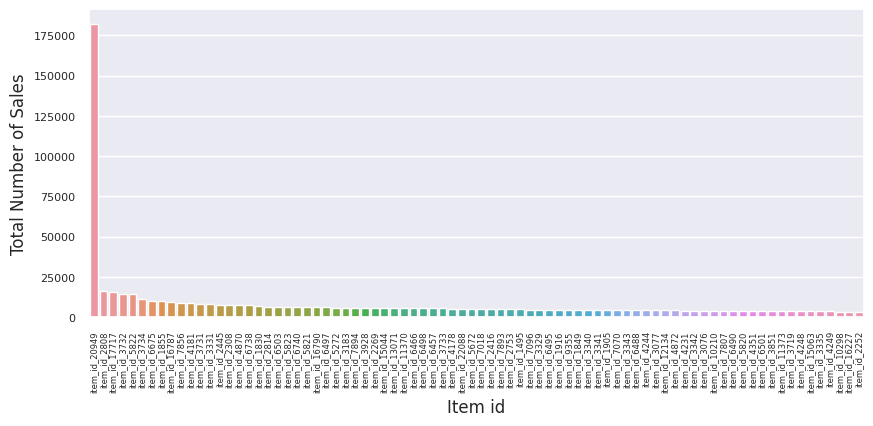

In [266]:
plt.figure(figsize=(10,4))
sns.barplot(items_total_sales_df.iloc[:,list(range(80))])
plt.xlabel("Item id")
plt.ylabel("Total Number of Sales")
plt.tick_params(axis='x', labelsize=6, rotation=90)
plt.tick_params(axis='y', labelsize=8)

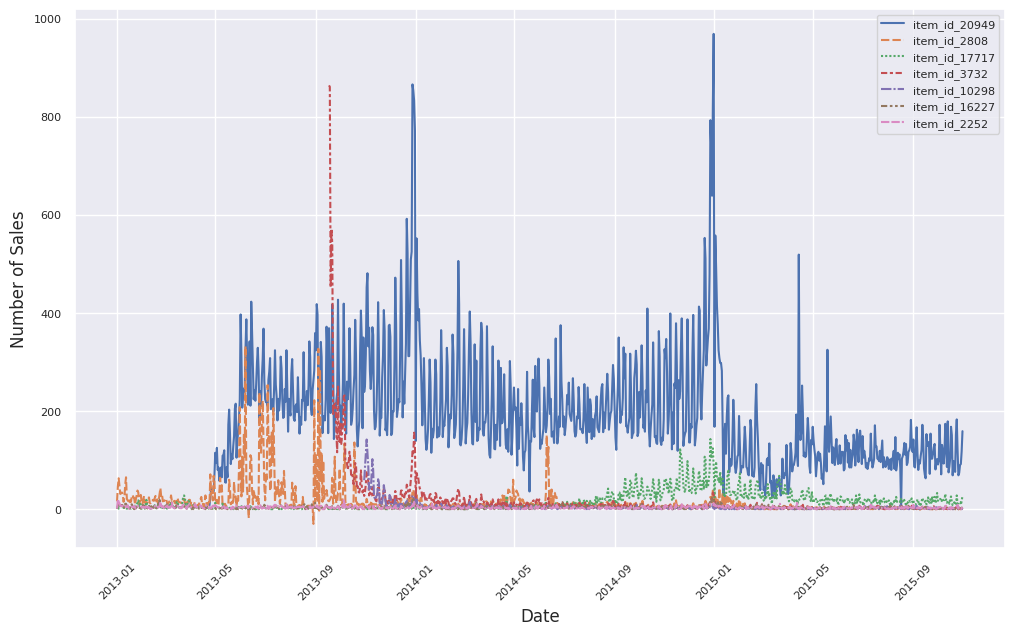

In [136]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=[
    items_sales.item_id_20949,
    items_sales.item_id_2808,
    items_sales.item_id_17717,
    items_sales.item_id_3732,
    items_sales.item_id_10298,
    items_sales.item_id_16227,
    items_sales.item_id_2252
])
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

In [267]:
# itens with no sale
len(items_no_sale)

363

### Sales Values per Week

## Total

In [311]:
total_sales_df = sales_df.resample(freq_analysis, on="date").sum()[['item_cnt_day']]
total_values_df = sales_df.resample(freq_analysis, on="date").sum()[['final_price']]

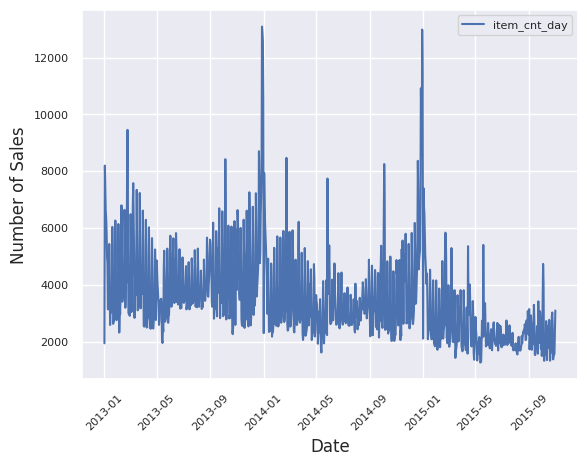

In [312]:
sns.lineplot(data=[total_sales_df['item_cnt_day']])
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

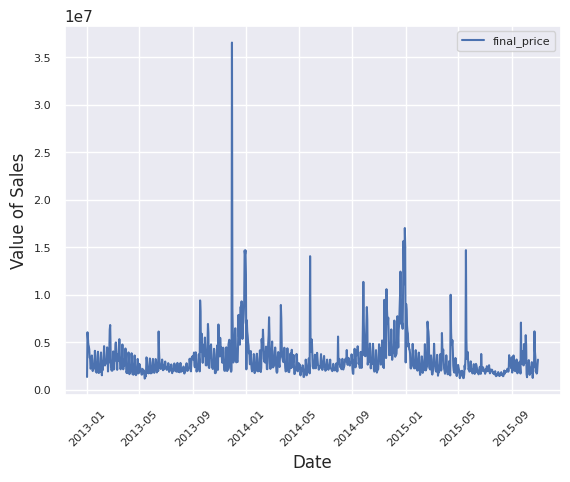

In [314]:
sns.lineplot(data=[total_values_df['final_price']])
plt.xlabel("Date")
plt.ylabel("Value of Sales")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

# Model Prophet

## Model Setup

In [315]:
# plot graph with train test and predict
def plot_forecast(prophet_dict: dict, lower=False, upper=False, left=None, right=None):
    plt.figure(figsize=(15, 8))
    plt.plot(prophet_dict['train']['ds'], prophet_dict['train']['y'], label="Train")
    plt.plot(prophet_dict['test']['ds'], prophet_dict['test']['y'], label="Test")
    plt.plot(
        prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
        prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat'],
        label="Pred")
    if lower:
        plt.plot(
            prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
            prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat_lower'],
            label="Lower")
    if upper:
        plt.plot(prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
                 prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat_upper'],
                 label="Upper")
    plt.legend(loc="best")
    if left is not None:
        left = dt.datetime.strptime(left, '%Y-%m').date()
    if right is not None:
        right = dt.datetime.strptime(right, '%Y-%m').date()
    plt.xlim(left=left, right=right)    
    plt.show()

In [316]:
# function to split the data between train and test
def set_train_data(df, split, frequency):
    df = df.reset_index()
    df.columns = ['ds', 'y']
    shape = df.shape[0]
    train_size = int(shape * split)
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    hor_dict = {'m': 2, 'w': 8, 'd':62} # two month, four weeks, 62 days
    horizon = (hor_dict[frequency]) + (shape - train_size)
    return train, test, horizon

In [317]:
# rum the Prophet model
def fit_prophet(data, split=0.90, seas_scale=10, inter_w=0.80, freq='d'):
    train_df, test_df, horizon = set_train_data(data, split, freq)
    
    model = Prophet(
        seasonality_mode='multiplicative', # or 'additive'
        seasonality_prior_scale=seas_scale, # default 10, smaller values dampen the seasonality
        interval_width=inter_w, # deaful 0.8, if mcmc < 0 will be integrated over all model parameters
        growth='linear', # is the default
        #yearly_seasonality=False, # default 'auto'
        #weekly_seasonality=True, # default 'auto'
        #daily_seasonality=False, # default 'auto'
        mcmc_samples=0, # default 0, if greater than 0, will do full Bayesian inference
    )
    model = model.fit(train_df)
    
    forecast = future_preds(model, horizon, freq)
    
    prophet_dict = {'model':model,
        'forecast':forecast,
        'train':train_df,
        'test':test_df,
        'horizon':horizon
    }
    
    return prophet_dict

In [318]:
# make future predictions
def future_preds(model, horizon, freq):
    future = model.make_future_dataframe(periods=horizon, freq=freq, )
    forecast = model.predict(future)
    # forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    return forecast    

## Total (Shop / Category)

### Fitting the Data and Making Future Predictions

In [333]:
# total_Shops_Number_sales_per_week
prophet_total_shops_sales = fit_prophet(
    total_sales_df,
    split=0.90,
    seas_scale=10,
    inter_w=0.80,
    freq=freq_analysis
)

# total_Shops_Values_per_week
prophet_total_shops_values = fit_prophet(
    total_values_df,
    split=0.90,
    seas_scale=10,
    inter_w=0.80,
    freq=freq_analysis
)

21:39:27 - cmdstanpy - INFO - Chain [1] start processing
21:39:27 - cmdstanpy - INFO - Chain [1] done processing
21:39:28 - cmdstanpy - INFO - Chain [1] start processing
21:39:28 - cmdstanpy - INFO - Chain [1] done processing


### Plotting the forecast

#### Shops Total Number of Sales per Week

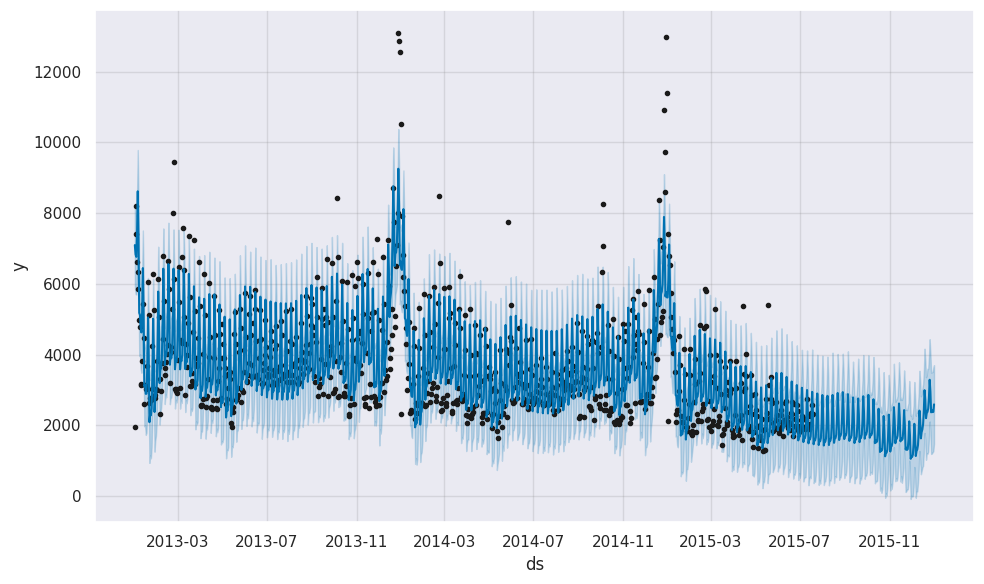

In [334]:
prophet_total_shops_sales['model'].plot(prophet_total_shops_sales['forecast']);

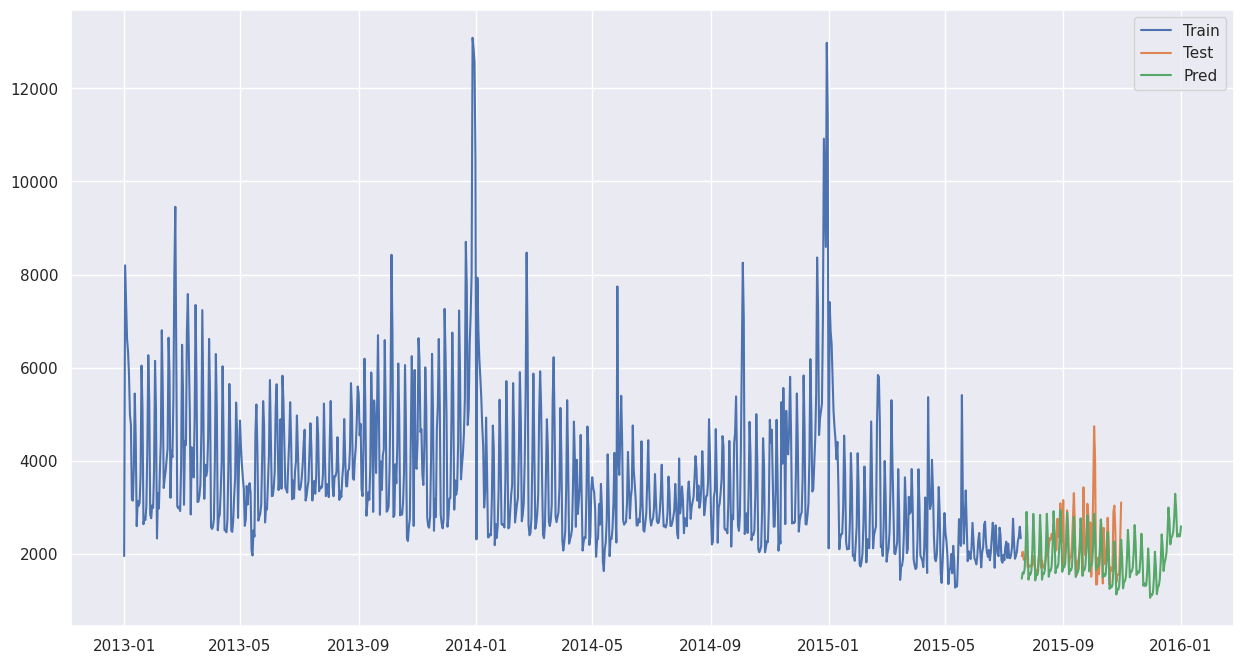

In [335]:
plot_forecast(prophet_total_shops_sales)

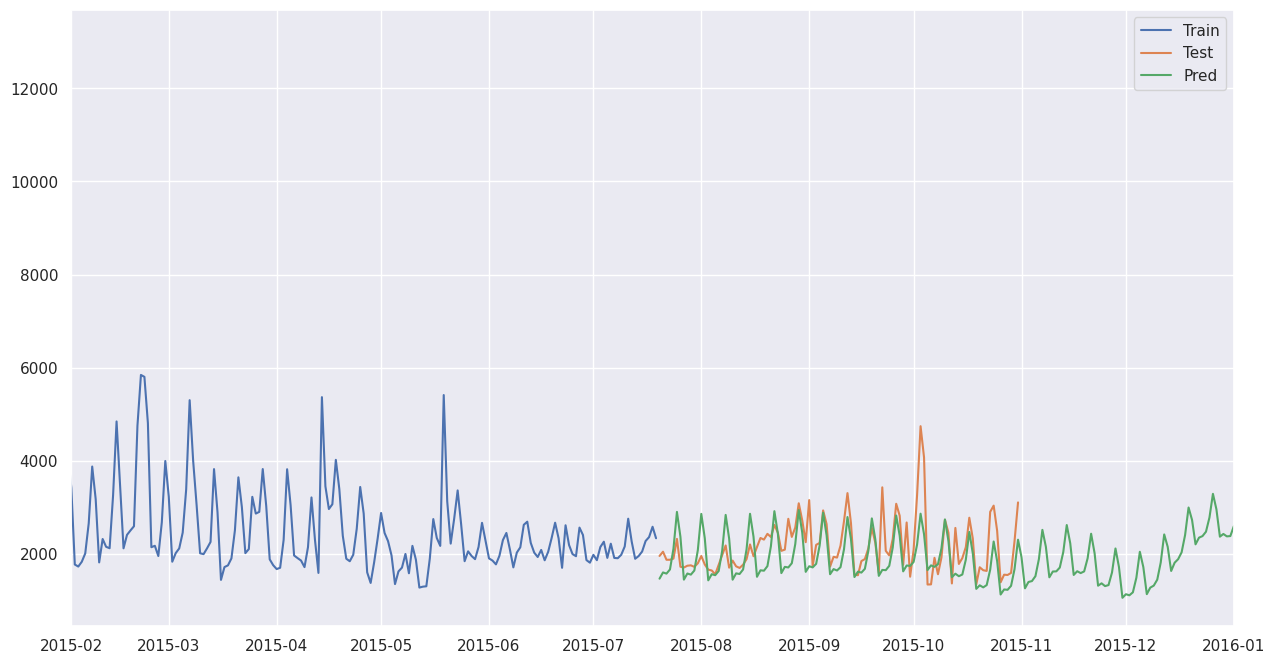

In [336]:
plot_forecast(prophet_total_shops_sales, left='2015-02', right='2016-01')

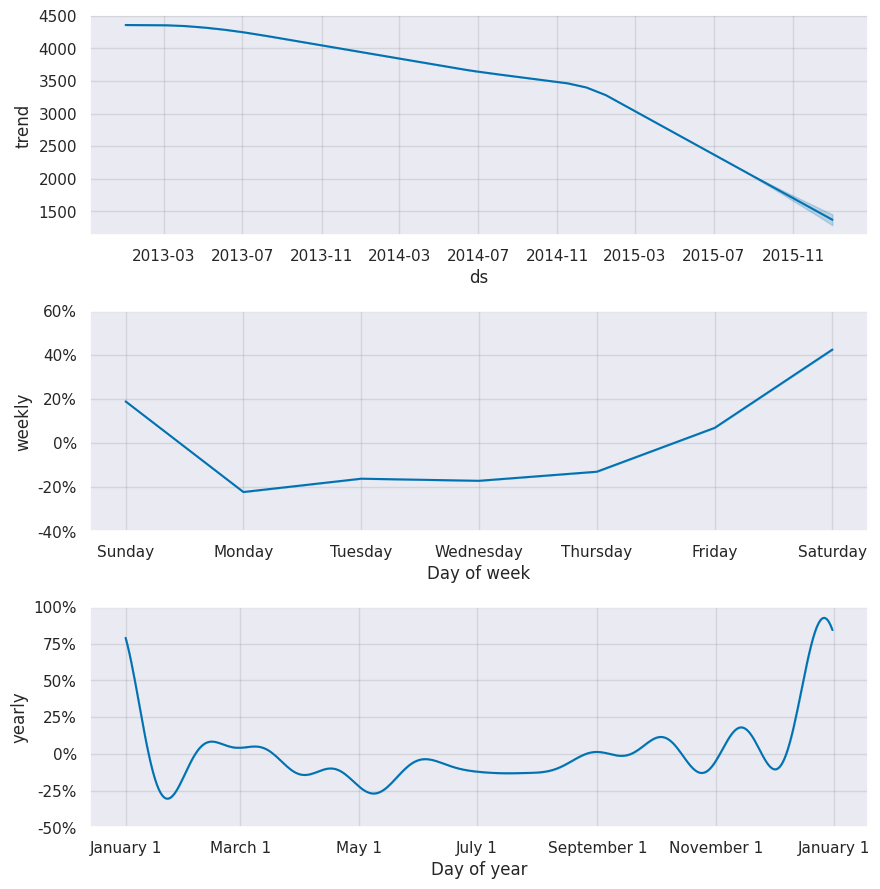

In [337]:
prophet_total_shops_sales['model'].plot_components(prophet_total_shops_sales['forecast']);

#### Shops Total Value of Sales per Week

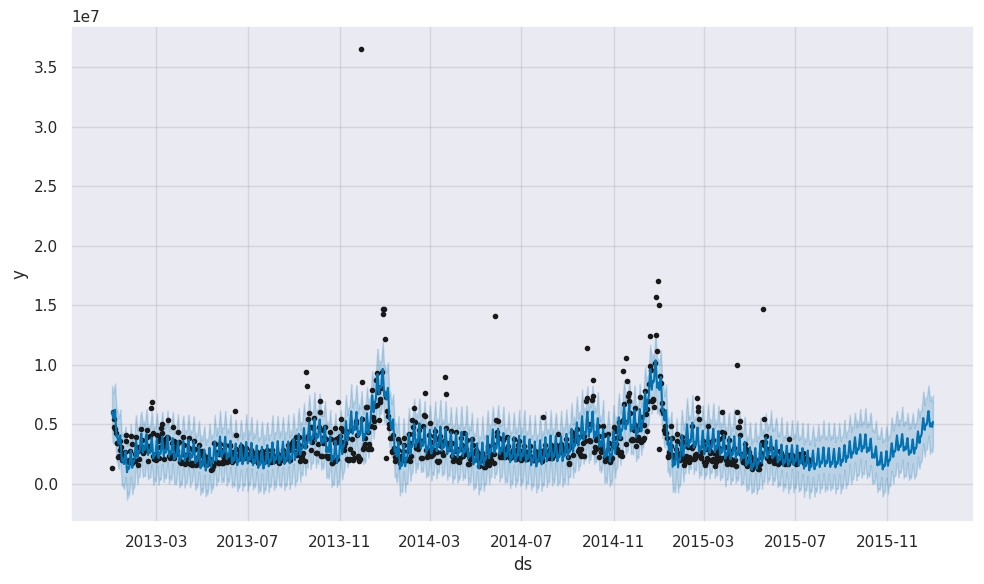

In [338]:
prophet_total_shops_values['model'].plot(prophet_total_shops_values['forecast']);

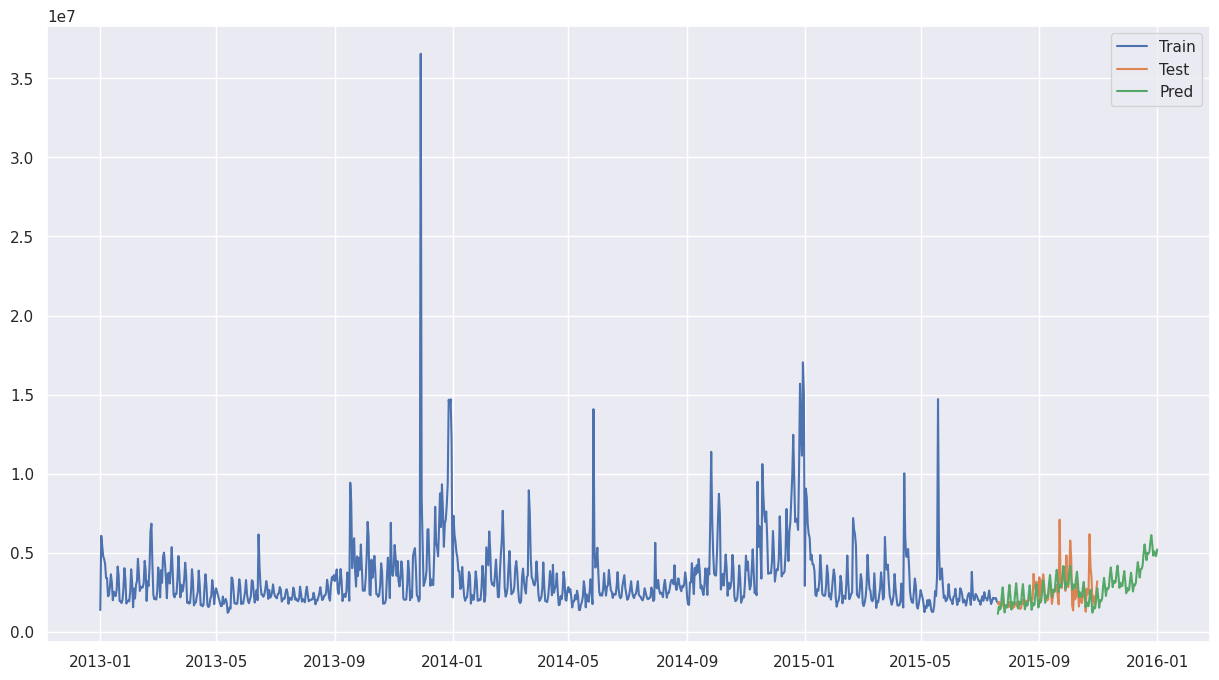

In [339]:
plot_forecast(prophet_total_shops_values)

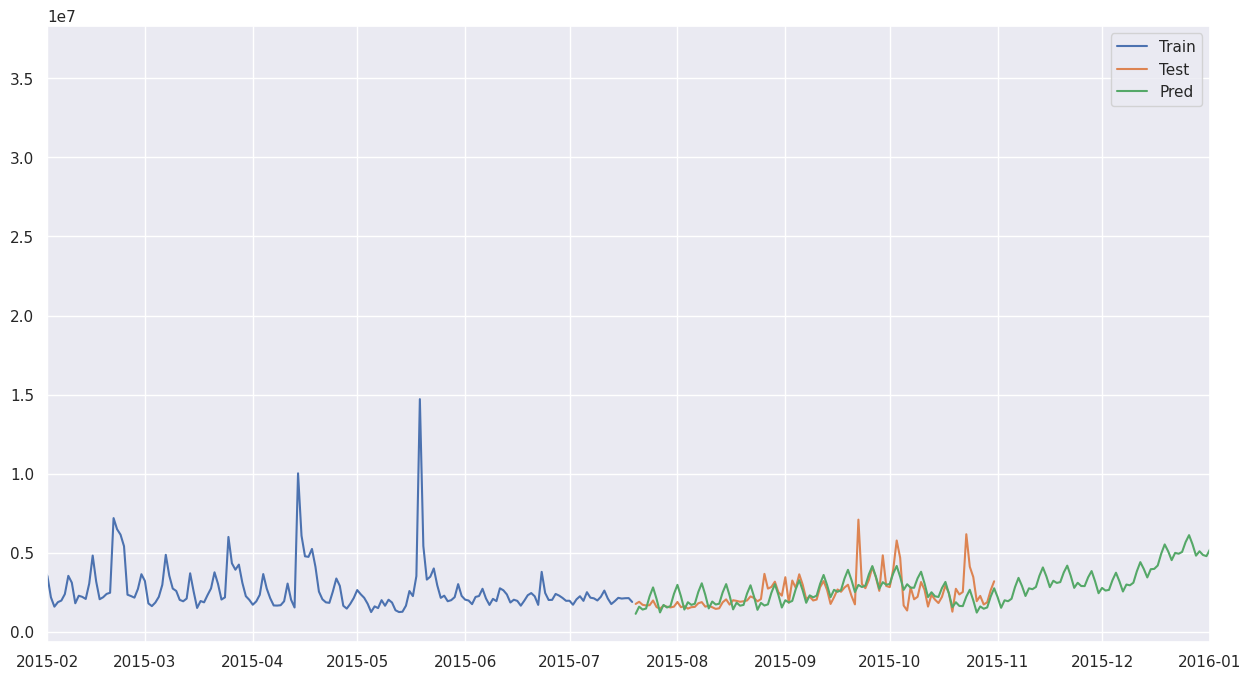

In [340]:
plot_forecast(prophet_total_shops_values, left='2015-02', right='2016-01')

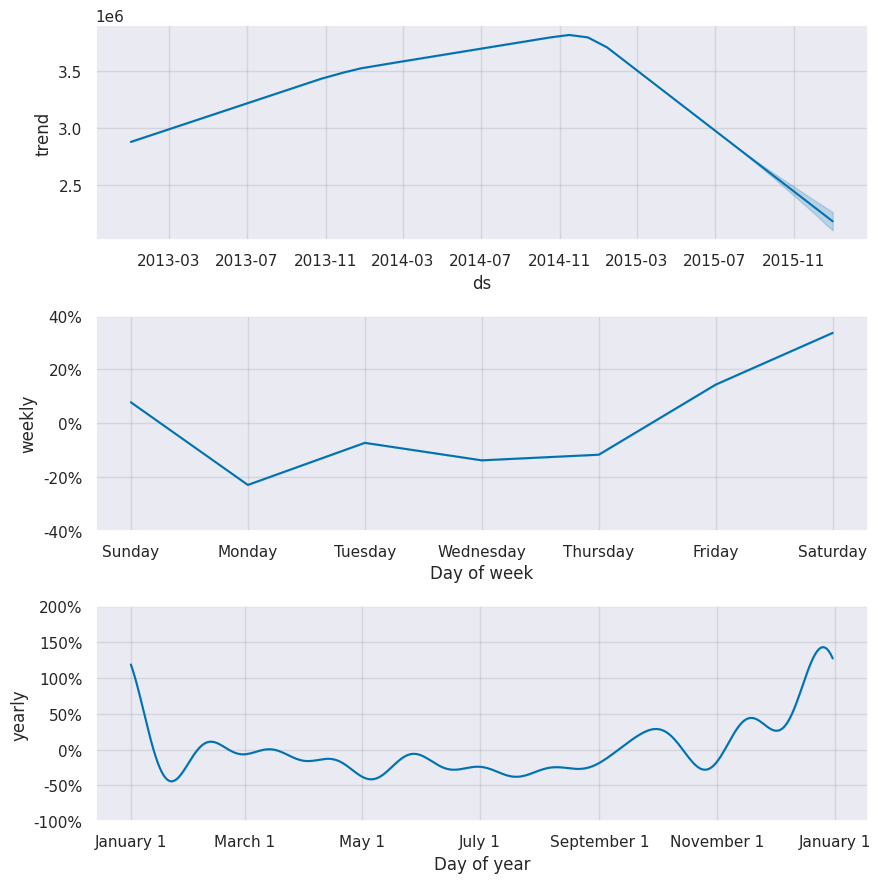

In [341]:
prophet_total_shops_values['model'].plot_components(prophet_total_shops_values['forecast']);

### Evaluating the model with cross-validation

In [342]:
# cross-validation for frequency daily
cv_results = cross_validation(
    model=prophet_total_shops_values['model'],
    initial='365.25 days', # one year
    horizon='31 days', # one month
    period='7 days'
)

  0%|          | 0/77 [00:00<?, ?it/s]

21:39:41 - cmdstanpy - INFO - Chain [1] start processing
21:39:41 - cmdstanpy - INFO - Chain [1] done processing
21:39:41 - cmdstanpy - INFO - Chain [1] start processing
21:39:41 - cmdstanpy - INFO - Chain [1] done processing
21:39:41 - cmdstanpy - INFO - Chain [1] start processing
21:39:41 - cmdstanpy - INFO - Chain [1] done processing
21:39:41 - cmdstanpy - INFO - Chain [1] start processing
21:39:41 - cmdstanpy - INFO - Chain [1] done processing
21:39:42 - cmdstanpy - INFO - Chain [1] start processing
21:39:42 - cmdstanpy - INFO - Chain [1] done processing
21:39:42 - cmdstanpy - INFO - Chain [1] start processing
21:39:42 - cmdstanpy - INFO - Chain [1] done processing
21:39:42 - cmdstanpy - INFO - Chain [1] start processing
21:39:42 - cmdstanpy - INFO - Chain [1] done processing
21:39:43 - cmdstanpy - INFO - Chain [1] start processing
21:39:43 - cmdstanpy - INFO - Chain [1] done processing
21:39:43 - cmdstanpy - INFO - Chain [1] start processing
21:39:43 - cmdstanpy - INFO - Chain [1]

21:40:00 - cmdstanpy - INFO - Chain [1] done processing
21:40:00 - cmdstanpy - INFO - Chain [1] start processing
21:40:00 - cmdstanpy - INFO - Chain [1] done processing
21:40:01 - cmdstanpy - INFO - Chain [1] start processing
21:40:01 - cmdstanpy - INFO - Chain [1] done processing
21:40:01 - cmdstanpy - INFO - Chain [1] start processing
21:40:01 - cmdstanpy - INFO - Chain [1] done processing
21:40:01 - cmdstanpy - INFO - Chain [1] start processing
21:40:01 - cmdstanpy - INFO - Chain [1] done processing


In [343]:
cv_results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-01-03,1.339978e+07,1.093206e+07,1.575977e+07,6157385.00,2014-01-02
1,2014-01-04,1.369880e+07,1.122631e+07,1.607696e+07,5692653.00,2014-01-02
2,2014-01-05,1.194626e+07,9.455014e+06,1.432062e+07,5023962.00,2014-01-02
3,2014-01-06,9.668329e+06,7.256805e+06,1.223855e+07,4686706.00,2014-01-02
4,2014-01-07,1.029946e+07,8.015997e+06,1.275727e+07,3847043.00,2014-01-02
...,...,...,...,...,...,...
2382,2015-07-15,1.502344e+06,-6.707423e+05,3.564565e+06,2143850.50,2015-06-18
2383,2015-07-16,1.545122e+06,-5.049338e+05,3.765993e+06,2098436.75,2015-06-18
2384,2015-07-17,2.319336e+06,2.392216e+05,4.590470e+06,2120300.25,2015-06-18
2385,2015-07-18,2.887997e+06,6.152622e+05,5.038344e+06,2127450.00,2015-06-18


In [344]:
df_p = performance_metrics(cv_results)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,1.947823e+12,1.395644e+06,9.300887e+05,0.260402,0.197040,0.235526,0.925898
1,5 days,3.609702e+12,1.899922e+06,1.056314e+06,0.309864,0.237886,0.283070,0.929717
2,6 days,3.983719e+12,1.995926e+06,1.128502e+06,0.346799,0.278868,0.321288,0.914057
3,7 days,4.401752e+12,2.098035e+06,1.217994e+06,0.369229,0.291263,0.331299,0.897632
4,8 days,3.351348e+12,1.830669e+06,1.199155e+06,0.373962,0.281260,0.317543,0.867074
5,9 days,3.294816e+12,1.815163e+06,1.216709e+06,0.350936,0.267071,0.288125,0.874714
6,10 days,3.092700e+12,1.758607e+06,1.163534e+06,0.320129,0.209681,0.259999,0.883499
7,11 days,2.310595e+12,1.520064e+06,9.981608e+05,0.295774,0.207706,0.252790,0.923224
8,12 days,3.875995e+12,1.968755e+06,1.093554e+06,0.341336,0.224438,0.293303,0.913293
9,13 days,4.134801e+12,2.033421e+06,1.135071e+06,0.369133,0.254243,0.323330,0.901070


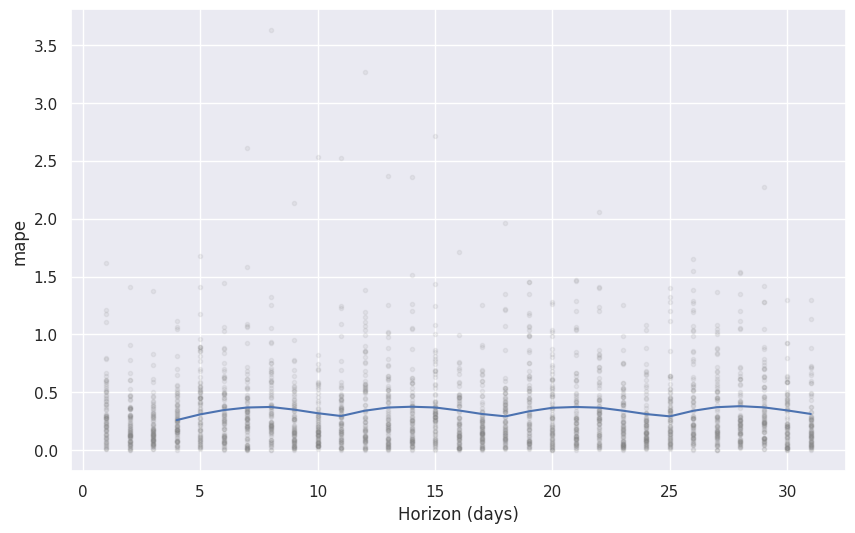

In [345]:
plot_cross_validation_metric(cv_results, metric='mape');

##  Shop

### Sales

In [ ]:
prophet_total_shops_sales = fit_prophet(
    total_sales_df,
    split=0.90,
    seas_scale=10,
    inter_w=0.80,
    freq=freq_analysis
)


In [347]:
shops_id_list = shops_sales.columns.to_list()
predict_shops_sales = {}
for shop in shops_id_list:
    df = shops_sales[shop].fillna(0)
    prophet_sales =  fit_prophet(
        data=df,
        split=1,
        seas_scale=10,
        inter_w=0.80,
        freq=freq_analysis
    )
    predict_shops_sales[shop] = prophet_sales

21:44:47 - cmdstanpy - INFO - Chain [1] start processing


shop_id_0


21:44:48 - cmdstanpy - INFO - Chain [1] done processing
21:44:48 - cmdstanpy - INFO - Chain [1] start processing


shop_id_1


21:44:48 - cmdstanpy - INFO - Chain [1] done processing
21:44:49 - cmdstanpy - INFO - Chain [1] start processing
21:44:49 - cmdstanpy - INFO - Chain [1] done processing


shop_id_2


21:44:49 - cmdstanpy - INFO - Chain [1] start processing
21:44:49 - cmdstanpy - INFO - Chain [1] done processing


shop_id_3


21:44:49 - cmdstanpy - INFO - Chain [1] start processing
21:44:49 - cmdstanpy - INFO - Chain [1] done processing


shop_id_4


21:44:50 - cmdstanpy - INFO - Chain [1] start processing
21:44:50 - cmdstanpy - INFO - Chain [1] done processing


shop_id_5


21:44:50 - cmdstanpy - INFO - Chain [1] start processing
21:44:50 - cmdstanpy - INFO - Chain [1] done processing


shop_id_6


21:44:51 - cmdstanpy - INFO - Chain [1] start processing
21:44:51 - cmdstanpy - INFO - Chain [1] done processing


shop_id_7


21:44:51 - cmdstanpy - INFO - Chain [1] start processing


shop_id_8


21:44:52 - cmdstanpy - INFO - Chain [1] done processing
21:44:52 - cmdstanpy - INFO - Chain [1] start processing
21:44:52 - cmdstanpy - INFO - Chain [1] done processing


shop_id_9


21:44:52 - cmdstanpy - INFO - Chain [1] start processing
21:44:52 - cmdstanpy - INFO - Chain [1] done processing


shop_id_10


21:44:53 - cmdstanpy - INFO - Chain [1] start processing


shop_id_11


21:44:53 - cmdstanpy - INFO - Chain [1] done processing
21:44:53 - cmdstanpy - INFO - Chain [1] start processing
21:44:53 - cmdstanpy - INFO - Chain [1] done processing


shop_id_12


21:44:54 - cmdstanpy - INFO - Chain [1] start processing
21:44:54 - cmdstanpy - INFO - Chain [1] done processing


shop_id_13


21:44:54 - cmdstanpy - INFO - Chain [1] start processing
21:44:54 - cmdstanpy - INFO - Chain [1] done processing


shop_id_14


21:44:55 - cmdstanpy - INFO - Chain [1] start processing
21:44:55 - cmdstanpy - INFO - Chain [1] done processing


shop_id_15


21:44:55 - cmdstanpy - INFO - Chain [1] start processing
21:44:55 - cmdstanpy - INFO - Chain [1] done processing


shop_id_16


21:44:56 - cmdstanpy - INFO - Chain [1] start processing
21:44:56 - cmdstanpy - INFO - Chain [1] done processing


shop_id_17


21:44:56 - cmdstanpy - INFO - Chain [1] start processing
21:44:56 - cmdstanpy - INFO - Chain [1] done processing


shop_id_18


21:44:56 - cmdstanpy - INFO - Chain [1] start processing
21:44:56 - cmdstanpy - INFO - Chain [1] done processing


shop_id_19


21:44:57 - cmdstanpy - INFO - Chain [1] start processing


shop_id_20


21:44:57 - cmdstanpy - INFO - Chain [1] done processing
21:44:57 - cmdstanpy - INFO - Chain [1] start processing
21:44:58 - cmdstanpy - INFO - Chain [1] done processing


shop_id_21


21:44:58 - cmdstanpy - INFO - Chain [1] start processing
21:44:58 - cmdstanpy - INFO - Chain [1] done processing


shop_id_22


21:44:58 - cmdstanpy - INFO - Chain [1] start processing


shop_id_23


21:44:59 - cmdstanpy - INFO - Chain [1] done processing
21:44:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing


shop_id_24


21:44:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing


shop_id_25


21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:00 - cmdstanpy - INFO - Chain [1] done processing


shop_id_26


21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:01 - cmdstanpy - INFO - Chain [1] done processing


shop_id_27


21:45:01 - cmdstanpy - INFO - Chain [1] start processing
21:45:01 - cmdstanpy - INFO - Chain [1] done processing


shop_id_28


21:45:01 - cmdstanpy - INFO - Chain [1] start processing
21:45:01 - cmdstanpy - INFO - Chain [1] done processing


shop_id_29


21:45:02 - cmdstanpy - INFO - Chain [1] start processing
21:45:02 - cmdstanpy - INFO - Chain [1] done processing


shop_id_30


21:45:02 - cmdstanpy - INFO - Chain [1] start processing
21:45:02 - cmdstanpy - INFO - Chain [1] done processing


shop_id_31


21:45:03 - cmdstanpy - INFO - Chain [1] start processing
21:45:03 - cmdstanpy - INFO - Chain [1] done processing


shop_id_32


21:45:03 - cmdstanpy - INFO - Chain [1] start processing
21:45:03 - cmdstanpy - INFO - Chain [1] done processing


shop_id_33


21:45:04 - cmdstanpy - INFO - Chain [1] start processing
21:45:04 - cmdstanpy - INFO - Chain [1] done processing


shop_id_34


21:45:04 - cmdstanpy - INFO - Chain [1] start processing
21:45:04 - cmdstanpy - INFO - Chain [1] done processing


shop_id_35


21:45:05 - cmdstanpy - INFO - Chain [1] start processing
21:45:05 - cmdstanpy - INFO - Chain [1] done processing


shop_id_36


21:45:05 - cmdstanpy - INFO - Chain [1] start processing
21:45:05 - cmdstanpy - INFO - Chain [1] done processing


shop_id_37


21:45:05 - cmdstanpy - INFO - Chain [1] start processing
21:45:05 - cmdstanpy - INFO - Chain [1] done processing


shop_id_38


21:45:06 - cmdstanpy - INFO - Chain [1] start processing
21:45:06 - cmdstanpy - INFO - Chain [1] done processing


shop_id_39


21:45:06 - cmdstanpy - INFO - Chain [1] start processing
21:45:06 - cmdstanpy - INFO - Chain [1] done processing


shop_id_40


21:45:07 - cmdstanpy - INFO - Chain [1] start processing
21:45:07 - cmdstanpy - INFO - Chain [1] done processing


shop_id_41


21:45:07 - cmdstanpy - INFO - Chain [1] start processing
21:45:07 - cmdstanpy - INFO - Chain [1] done processing


shop_id_42


21:45:08 - cmdstanpy - INFO - Chain [1] start processing
21:45:08 - cmdstanpy - INFO - Chain [1] done processing


shop_id_43


21:45:08 - cmdstanpy - INFO - Chain [1] start processing
21:45:08 - cmdstanpy - INFO - Chain [1] done processing


shop_id_44


21:45:09 - cmdstanpy - INFO - Chain [1] start processing
21:45:09 - cmdstanpy - INFO - Chain [1] done processing


shop_id_45


21:45:09 - cmdstanpy - INFO - Chain [1] start processing
21:45:09 - cmdstanpy - INFO - Chain [1] done processing


shop_id_46


21:45:09 - cmdstanpy - INFO - Chain [1] start processing
21:45:09 - cmdstanpy - INFO - Chain [1] done processing


shop_id_47


21:45:10 - cmdstanpy - INFO - Chain [1] start processing
21:45:10 - cmdstanpy - INFO - Chain [1] done processing


shop_id_48


21:45:10 - cmdstanpy - INFO - Chain [1] start processing
21:45:11 - cmdstanpy - INFO - Chain [1] done processing


shop_id_49


21:45:11 - cmdstanpy - INFO - Chain [1] start processing
21:45:11 - cmdstanpy - INFO - Chain [1] done processing


shop_id_50


21:45:11 - cmdstanpy - INFO - Chain [1] start processing
21:45:11 - cmdstanpy - INFO - Chain [1] done processing


shop_id_51


21:45:12 - cmdstanpy - INFO - Chain [1] start processing
21:45:12 - cmdstanpy - INFO - Chain [1] done processing


shop_id_52


21:45:12 - cmdstanpy - INFO - Chain [1] start processing
21:45:12 - cmdstanpy - INFO - Chain [1] done processing


shop_id_53


21:45:12 - cmdstanpy - INFO - Chain [1] start processing
21:45:13 - cmdstanpy - INFO - Chain [1] done processing


shop_id_54


21:45:13 - cmdstanpy - INFO - Chain [1] start processing
21:45:13 - cmdstanpy - INFO - Chain [1] done processing


shop_id_55


21:45:14 - cmdstanpy - INFO - Chain [1] start processing
21:45:14 - cmdstanpy - INFO - Chain [1] done processing


shop_id_56


21:45:14 - cmdstanpy - INFO - Chain [1] start processing
21:45:14 - cmdstanpy - INFO - Chain [1] done processing


shop_id_57


21:45:14 - cmdstanpy - INFO - Chain [1] start processing
21:45:15 - cmdstanpy - INFO - Chain [1] done processing


shop_id_58


21:45:15 - cmdstanpy - INFO - Chain [1] start processing
21:45:15 - cmdstanpy - INFO - Chain [1] done processing


shop_id_59


### Values

In [349]:
shops_id_list = shops_values.columns.to_list()
predict_shops_values = {}
for shop in shops_id_list:
    df = shops_values[shop].fillna(0)
    prophet_values =  fit_prophet(
        data=df,
        split=1,
        seas_scale=10,
        inter_w=0.80,
        freq=freq_analysis
    )
    predict_shops_values[shop] = prophet_values

21:45:36 - cmdstanpy - INFO - Chain [1] start processing


shop_id_0


21:45:36 - cmdstanpy - INFO - Chain [1] done processing
21:45:37 - cmdstanpy - INFO - Chain [1] start processing


shop_id_1


21:45:37 - cmdstanpy - INFO - Chain [1] done processing
21:45:38 - cmdstanpy - INFO - Chain [1] start processing
21:45:38 - cmdstanpy - INFO - Chain [1] done processing


shop_id_2


21:45:38 - cmdstanpy - INFO - Chain [1] start processing
21:45:38 - cmdstanpy - INFO - Chain [1] done processing


shop_id_3


21:45:38 - cmdstanpy - INFO - Chain [1] start processing
21:45:38 - cmdstanpy - INFO - Chain [1] done processing


shop_id_4


21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing


shop_id_5


21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing


shop_id_6


21:45:40 - cmdstanpy - INFO - Chain [1] start processing
21:45:40 - cmdstanpy - INFO - Chain [1] done processing


shop_id_7


21:45:40 - cmdstanpy - INFO - Chain [1] start processing


shop_id_8


21:45:40 - cmdstanpy - INFO - Chain [1] done processing
21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing


shop_id_9


21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing


shop_id_10


21:45:42 - cmdstanpy - INFO - Chain [1] start processing
21:45:42 - cmdstanpy - INFO - Chain [1] done processing


shop_id_11


21:45:42 - cmdstanpy - INFO - Chain [1] start processing
21:45:42 - cmdstanpy - INFO - Chain [1] done processing


shop_id_12


21:45:43 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing


shop_id_13


21:45:43 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing


shop_id_14


21:45:43 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing


shop_id_15


21:45:44 - cmdstanpy - INFO - Chain [1] start processing
21:45:44 - cmdstanpy - INFO - Chain [1] done processing


shop_id_16


21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:45 - cmdstanpy - INFO - Chain [1] done processing


shop_id_17


21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:45 - cmdstanpy - INFO - Chain [1] done processing


shop_id_18


21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:45 - cmdstanpy - INFO - Chain [1] done processing


shop_id_19


21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing


shop_id_20


21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing


shop_id_21


21:45:47 - cmdstanpy - INFO - Chain [1] start processing
21:45:47 - cmdstanpy - INFO - Chain [1] done processing


shop_id_22


21:45:47 - cmdstanpy - INFO - Chain [1] start processing


shop_id_23


21:45:47 - cmdstanpy - INFO - Chain [1] done processing
21:45:48 - cmdstanpy - INFO - Chain [1] start processing
21:45:48 - cmdstanpy - INFO - Chain [1] done processing


shop_id_24


21:45:48 - cmdstanpy - INFO - Chain [1] start processing
21:45:48 - cmdstanpy - INFO - Chain [1] done processing


shop_id_25


21:45:49 - cmdstanpy - INFO - Chain [1] start processing
21:45:49 - cmdstanpy - INFO - Chain [1] done processing


shop_id_26


21:45:49 - cmdstanpy - INFO - Chain [1] start processing
21:45:49 - cmdstanpy - INFO - Chain [1] done processing


shop_id_27


21:45:49 - cmdstanpy - INFO - Chain [1] start processing
21:45:49 - cmdstanpy - INFO - Chain [1] done processing


shop_id_28


21:45:50 - cmdstanpy - INFO - Chain [1] start processing
21:45:50 - cmdstanpy - INFO - Chain [1] done processing


shop_id_29


21:45:50 - cmdstanpy - INFO - Chain [1] start processing
21:45:50 - cmdstanpy - INFO - Chain [1] done processing


shop_id_30


21:45:51 - cmdstanpy - INFO - Chain [1] start processing
21:45:51 - cmdstanpy - INFO - Chain [1] done processing


shop_id_31


21:45:51 - cmdstanpy - INFO - Chain [1] start processing
21:45:51 - cmdstanpy - INFO - Chain [1] done processing


shop_id_32


21:45:52 - cmdstanpy - INFO - Chain [1] start processing
21:45:52 - cmdstanpy - INFO - Chain [1] done processing


shop_id_33


21:45:52 - cmdstanpy - INFO - Chain [1] start processing
21:45:52 - cmdstanpy - INFO - Chain [1] done processing


shop_id_34


21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:45:53 - cmdstanpy - INFO - Chain [1] done processing


shop_id_35


21:45:53 - cmdstanpy - INFO - Chain [1] start processing


shop_id_36


21:45:53 - cmdstanpy - INFO - Chain [1] done processing
21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing


shop_id_37


21:45:54 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing


shop_id_38


21:45:55 - cmdstanpy - INFO - Chain [1] start processing
21:45:55 - cmdstanpy - INFO - Chain [1] done processing


shop_id_39


21:45:55 - cmdstanpy - INFO - Chain [1] start processing
21:45:55 - cmdstanpy - INFO - Chain [1] done processing


shop_id_40


21:45:55 - cmdstanpy - INFO - Chain [1] start processing
21:45:55 - cmdstanpy - INFO - Chain [1] done processing


shop_id_41


21:45:56 - cmdstanpy - INFO - Chain [1] start processing
21:45:56 - cmdstanpy - INFO - Chain [1] done processing


shop_id_42


21:45:56 - cmdstanpy - INFO - Chain [1] start processing
21:45:56 - cmdstanpy - INFO - Chain [1] done processing


shop_id_43


21:45:57 - cmdstanpy - INFO - Chain [1] start processing
21:45:57 - cmdstanpy - INFO - Chain [1] done processing


shop_id_44


21:45:57 - cmdstanpy - INFO - Chain [1] start processing
21:45:57 - cmdstanpy - INFO - Chain [1] done processing


shop_id_45


21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:45:58 - cmdstanpy - INFO - Chain [1] done processing


shop_id_46


21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:45:58 - cmdstanpy - INFO - Chain [1] done processing


shop_id_47


21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing


shop_id_48


21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing


shop_id_49


21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing


shop_id_50


21:46:00 - cmdstanpy - INFO - Chain [1] start processing
21:46:00 - cmdstanpy - INFO - Chain [1] done processing


shop_id_51


21:46:00 - cmdstanpy - INFO - Chain [1] start processing
21:46:00 - cmdstanpy - INFO - Chain [1] done processing


shop_id_52


21:46:01 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing


shop_id_53


21:46:01 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing


shop_id_54


21:46:02 - cmdstanpy - INFO - Chain [1] start processing
21:46:02 - cmdstanpy - INFO - Chain [1] done processing


shop_id_55


21:46:02 - cmdstanpy - INFO - Chain [1] start processing
21:46:02 - cmdstanpy - INFO - Chain [1] done processing


shop_id_56


21:46:03 - cmdstanpy - INFO - Chain [1] start processing
21:46:03 - cmdstanpy - INFO - Chain [1] done processing


shop_id_57


21:46:03 - cmdstanpy - INFO - Chain [1] start processing
21:46:03 - cmdstanpy - INFO - Chain [1] done processing


shop_id_58


21:46:04 - cmdstanpy - INFO - Chain [1] start processing
21:46:04 - cmdstanpy - INFO - Chain [1] done processing


shop_id_59


In [356]:
predict_shops_values['shop_id_23']

{'model': <prophet.forecaster.Prophet at 0x7efe140d4a90>,
 'forecast':              ds         trend    yhat_lower    yhat_upper   trend_lower  \
 0    2013-01-01  20527.323410  29218.322060  42907.509160  20527.323410   
 1    2013-01-02  20444.577256  31728.868186  45240.632747  20444.577256   
 2    2013-01-03  20361.831103  38065.383786  52023.206814  20361.831103   
 3    2013-01-04  20279.084949  46702.106379  60312.393059  20279.084949   
 4    2013-01-05  20196.338795  85610.197082  98684.469479  20196.338795   
 ...         ...           ...           ...           ...           ...   
 1091 2015-12-28      3.863663  -7035.841686   6508.431171   -411.803620   
 1092 2015-12-29      3.883286  -6398.680675   7319.450885   -426.779650   
 1093 2015-12-30      3.902908  -6645.587036   6461.334845   -441.118640   
 1094 2015-12-31      3.922531  -6555.033413   6459.199551   -451.493386   
 1095 2016-01-01      3.942153  -6710.820236   6951.029502   -460.888931   
 
        trend_up

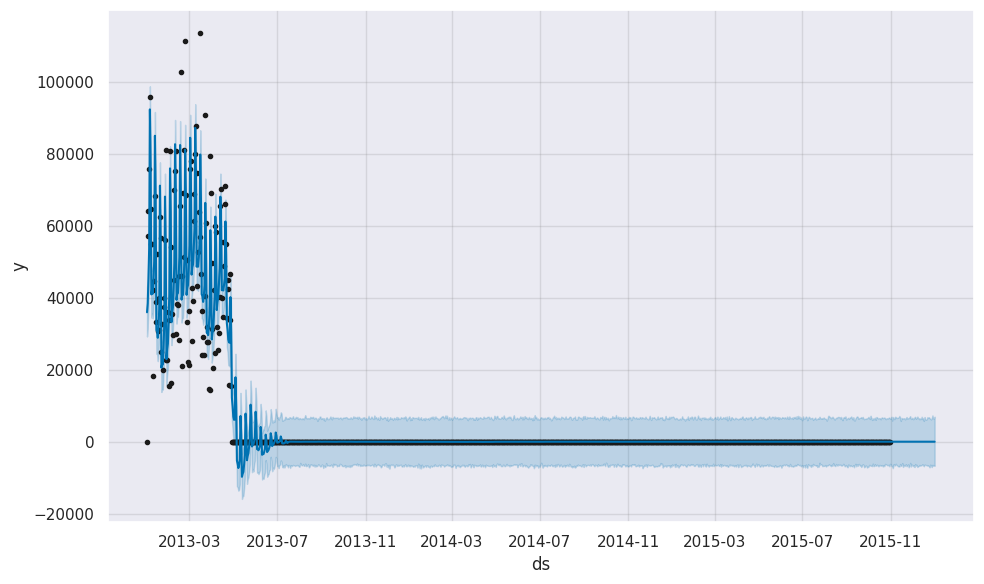

In [357]:
predict_shops_values['shop_id_23']['model'].plot(predict_shops_values['shop_id_23']['forecast']);

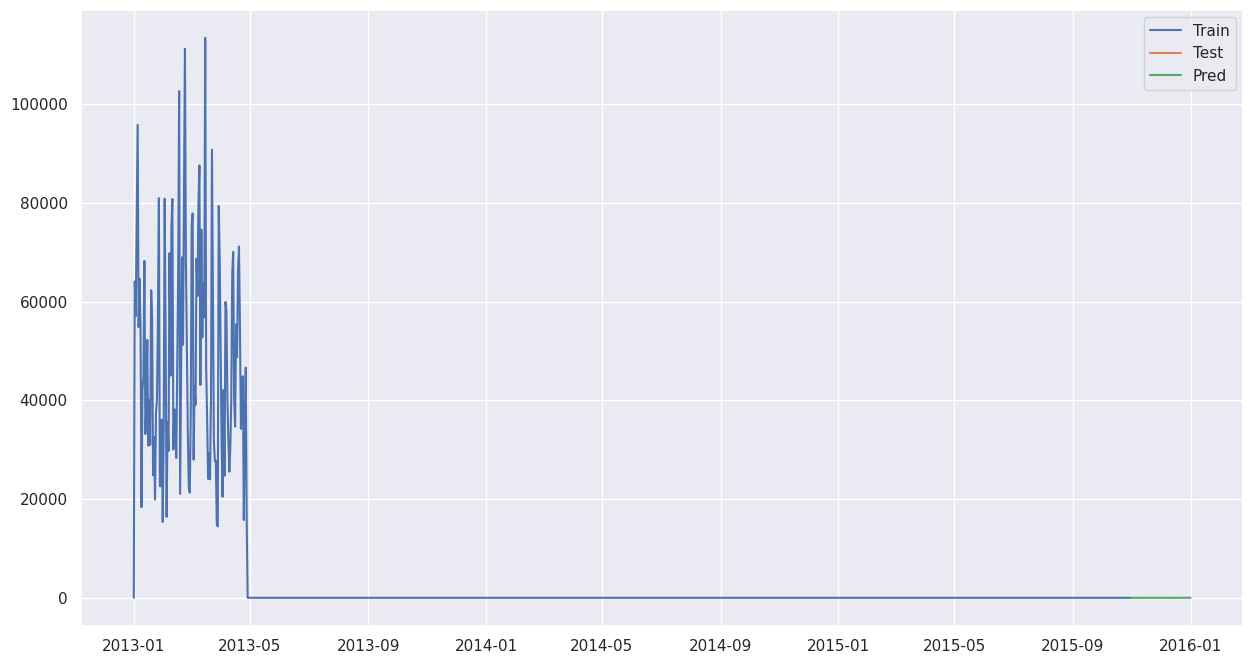

In [358]:
plot_forecast(predict_shops_values['shop_id_23'])

## Category

# Data Old and What?

## one

In [ ]:
sales_df.sample(10)

In [ ]:
sales_df.describe()

In [ ]:
sales_df.item_cnt_day.nunique()

In [ ]:
open_shops = np.sort(test_df['shop_id'].unique())
open_shops

In [ ]:
test_df.nunique()

In [ ]:
print("Categories:", categories_df.shape)
print("Items:", items_df.shape)
print("Shops:", shops_df.shape)
print("Sales:", sales_df.shape)
print("Test:", test_df.shape)
print("Sample:", sample_df.shape)

In [ ]:
# Total shop * itens, diff with sample
total = items_df.shape[0] * shops_df.shape[0]
print("Total shop * itens:", total)
print("Diffrence with the smple:", total - sample_df.shape[0])

In [ ]:
sales_df.dtypes

In [ ]:
sales_df

In [ ]:
shops_sales_month = pd.pivot_table(
    sales_df, values='item_cnt_day',
    index=['shop_id', 'item_id'], columns=['date_block_num'],
    aggfunc=np.sum 
)
shops_sales_month.fillna(0, inplace=True)
shops_sales_month.reset_index(inplace=True)

In [ ]:
shops_sales_month

In [ ]:
shops_sales_month['final_id'] = shops_sales_month['shop_id'].astype(str) + "-" + shops_sales_month['item_id'].astype(str)
shops_sales_month.set_index('final_id', inplace=True)
shops_sales_month.drop(columns=['shop_id', 'item_id'], inplace=True)
shops_sales_month = shops_sales_month.T

In [ ]:
shops_sales_month

In [ ]:
plot_cols = ['0-32', '0-49', '59-22144', '59-22167']
plot_features = shops_sales_month[plot_cols]
plot_features.index = shops_sales_month.index
plot_features.plot(subplots = True);

## two

In [ ]:
sales_df[sales_df['shop_id'] == 10].sort_values("date").groupby(by='date').sum('item_cnt_day')

In [ ]:
shop_sales_month =pd.DataFrame({"date_block_num": range(34)})
type(shop_sales_month)

In [ ]:
total_month_dict = {}
for id in range(shops_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_df[sales_df['shop_id'] == id].groupby(by='date_block_num').sum('item_cnt_day')
    total_month_dict[shop_id] = df.shape[0]
    shop_sales_month[shop_id] = df.item_cnt_day
shop_sales_month.fillna(0, inplace=True)
shop_sales_month.drop(columns=['date_block_num'], inplace=True)

In [ ]:
shop_sales_month

In [ ]:
closed_shops = shop_sales_month.iloc[31:34]
closed_shops = pd.DataFrame(shop_sales_month.iloc[31:34].sum()).T
closed_shops

In [ ]:
pd.DataFrame(shop_sales_month.iloc[31:34].sum()).head(60)

In [ ]:
plt.plot(shop_sales_month.shop_id_0)
plt.plot(shop_sales_month.shop_id_1)
plt.plot(shop_sales_month.shop_id_8)
plt.plot(shop_sales_month.shop_id_9)

plt.plot(shop_sales_month.shop_id_11)
plt.plot(shop_sales_month.shop_id_13)
plt.plot(shop_sales_month.shop_id_17)
plt.plot(shop_sales_month.shop_id_20)
plt.plot(shop_sales_month.shop_id_23)
plt.plot(shop_sales_month.shop_id_27)

plt.plot(shop_sales_month.shop_id_29)
plt.plot(shop_sales_month.shop_id_30)
plt.plot(shop_sales_month.shop_id_32)
plt.plot(shop_sales_month.shop_id_33)
plt.plot(shop_sales_month.shop_id_40)
plt.plot(shop_sales_month.shop_id_27)


plt.plot(shop_sales_month.shop_id_43)
plt.plot(shop_sales_month.shop_id_51)
plt.plot(shop_sales_month.shop_id_54)
plt.plot(range(34))

In [ ]:
plt.plot(shop_sales_month.shop_id_27)
#plt.plot(shop_sales_month.shop_id_41)
#plt.plot(shop_sales_month.shop_id_42)
#plt.plot(shop_sales_month.shop_id_43)
#plt.plot(shop_sales_month.shop_id_44)
#plt.plot(shop_sales_month.shop_id_45)
#plt.plot(shop_sales_month.shop_id_46)

In [ ]:
sns.displot(total_month_dict, bins=34)
plt.xlim(1, 35, )

In [ ]:
total_month_dict

In [ ]:
open_shops